In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from scipy.optimize import minimize

 ## Этап 1. EDA: изучить данные с датчиков и лабораторные анализы

* ### Загрузка данных

In [49]:
data1 = pd.read_csv('data1.csv')
data2 = pd.read_csv('data2.csv')

* ### Фильтрация данных

 ### 1) Удаление ошибочных измерений плотностей

In [50]:
def filtrate_by_density(data):
    condition = (data['ro1'] >= 1.0) & (data['ro1'] <= 2.5) & \
            (data['ro2'] >= 1.0) & (data['ro2'] <= 2.5) & \
            (data['ro3'] >= 1.0) & (data['ro3'] <= 2.5) & \
            (data['ro4'] >= 1.0) & (data['ro4'] <= 2.5) & \
            (data['ro_final'] >= 1.0) & (data['ro_final'] <= 2.5)
    return data[condition]

In [66]:
df1 = filtrate_by_density(data1)
df2 = filtrate_by_density(data2)
print("Количество измерений с плотностью вне данного дианазона data1.csv:" , len(data1)-len(df1))
print("Количество измерений с плотностью вне данного дианазона data2.csv:" , len(data2)-len(df1))
df1['DateTime'] = pd.to_datetime(df1['DateTime'])
df2['DateTime'] = pd.to_datetime(df2['DateTime'])

Количество измерений с плотностью вне данного дианазона data1.csv: 283517
Количество измерений с плотностью вне данного дианазона data2.csv: 283517


В дальнейшем, работаем с одним баком.

In [67]:
display(df1)

DateTime   Ni1     S1  Fe3O41   Ni2     S2  Fe3O42   Ni3  \
0      2021-01-01 00:00:00  5.45  22.39     1.5  3.87  17.52     1.7  8.62   
1      2021-01-01 00:01:00  5.45  22.39     1.5  3.87  17.52     1.7  8.62   
2      2021-01-01 00:02:00  5.45  22.39     1.5  3.87  17.52     1.7  8.62   
3      2021-01-01 00:03:00  5.45  22.39     1.5  3.87  17.52     1.7  8.62   
4      2021-01-01 00:04:00  5.45  22.39     1.5  3.87  17.52     1.7  8.62   
...                    ...   ...    ...     ...   ...    ...     ...   ...   
772062 2022-06-20 23:54:00  4.75  21.60     1.3  7.25  17.20     2.9  5.94   
772063 2022-06-20 23:55:00  4.75  21.60     1.3  7.25  17.20     2.9  5.94   
772064 2022-06-20 23:56:00  4.75  21.60     1.3  7.25  17.20     2.9  5.94   
772065 2022-06-20 23:57:00  4.75  21.60     1.3  7.25  17.20     2.9  5.94   
772066 2022-06-20 23:58:00  4.75  21.60     1.3  7.25  17.20     2.9  5.94   

           S3  Fe3O43  ...      ro2      ro3      ro4  ro_final  ust1  ust2  \
0       13.21     5.0  ...  1.68910  2.01670  1.86565    1.8684   0.0   0.0   
1       13.21     5.0  ...  1.69955  2.02900  1.86145    1.8752   0.0   0.0   
2       13.21     5.0  ...  1.69980  2.04530  1.85210    1.8635   0.0   0.0   
3       13.21     5.0  ...  1.69845  2.05230  1.84420    1.8572   0.0   0.0   
4       13.21     5.0  ...  1.69470  2.06035  1.83950    1.8526   0.0   0.0   
...       ...     ...  ...      ...      ...      ...       ...   ...   ...   
772062  21.90     2.2  ...  1.00000  1.00000  1.83540    1.9116  30.0  40.0   
772063  21.90     2.2  ...  1.00000  1.00000  1.83505    1.9116  30.0  40.0   
772064  21.90     2.2  ...  1.00000  1.00000  1.83465    1.9116  30.0  40.0   
772065  21.90     2.2  ...  1.00000  1.00000  1.83425    1.9116  30.0  40.0   
772066  21.90     2.2  ...  1.00000  1.00000  1.83385    1.9117  30.0  40.0   

        ust3   ust4  v_final  level_final  
0         44   97.0      179      69.2796  
1         44   97.0      179      69.1331  
2         44   97.0      179      66.7399  
3         44   97.0      179      64.2247  
4         44   97.0      179      62.2955  
...      ...    ...      ...          ...  
772062     0  140.0        0      -1.0000  
772063     0  140.0        0      -1.0000  
772064     0  140.0        0      -1.0000  
772065     0  140.0        0      -1.0000  
772066     0  140.0        0      -1.0000  

[488550 rows x 27 columns]

### 2) Удаление дубликатов

Посмотрим распределения дубликатов по дням.

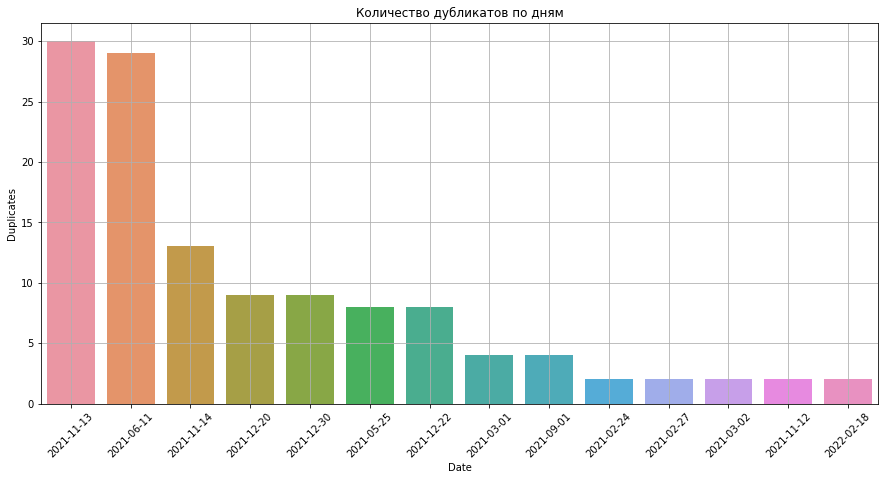

In [75]:
duplicate_rows_time = df1[df1.duplicated(subset=['DateTime'], keep=False)]
duplicate_rows_time['Date'] = duplicate_rows_time['DateTime'].dt.date
date_counts = duplicate_rows_time['Date'].value_counts().reset_index()
date_counts.columns = ['Date', 'Duplicates']

plt.figure(figsize=(15, 7))
sns.barplot(data=date_counts, x='Date', y='Duplicates')
plt.xticks(rotation=45)
plt.title('Количество дубликатов по дням')
plt.grid(True)
plt.show()

In [11]:
duplicates = df1.duplicated(subset='DateTime', keep=False)  
count_duplicates = duplicates.sum()
print("Количество дубликатов по столбцу DateTimе:", count_duplicates)
df1 = df1.drop_duplicates(subset='DateTime', keep = 'first')

Количество дубликатов по столбцу DateTimе: 124


Видно, что распределение дубликатов не случайное, в некоторые даты количество дубликатов большое.
В дальней обработке, обратим внимание, существуют ли еще некоторые странности в данных на эти даты. 

In [99]:
df1.describe()

Ni1             S1         Fe3O41            Ni2  \
count  488448.000000  488448.000000  488448.000000  488448.000000   
mean        5.570088      19.540227       2.020945       5.940397   
std         1.268834       2.701274       0.868737       1.816906   
min         3.660000       9.930000       0.700000       2.890000   
25%         4.730000      19.000000       1.500000       4.500000   
50%         5.180000      20.200000       1.800000       5.300000   
75%         6.030000      21.200000       2.200000       7.670000   
max         9.600000      27.700000       6.200000      10.240000   

                  S2         Fe3O42            Ni3             S3  \
count  488448.000000  488448.000000  488448.000000  488448.000000   
mean       17.570919       2.575187       7.626803      19.579723   
std         3.061700       1.348685       1.326784       3.886534   
min         8.100000       0.200000       4.130000      11.300000   
25%        16.150000       1.600000       6.620000      16.700000   
50%        18.490000       2.000000       7.430000      18.840000   
75%        19.500000       3.500000       8.480000      21.900000   
max        29.540000       7.900000      10.890000      38.300000   

              Fe3O43            Ni4  ...            ro2            ro3  \
count  488448.000000  488448.000000  ...  488448.000000  488448.000000   
mean        2.435386       8.921536  ...       1.643056       1.709564   
std         1.158174       0.478792  ...       0.461167       0.356307   
min         0.300000       4.540000  ...       1.000000       1.000000   
25%         1.800000       8.670000  ...       1.172000       1.626850   
50%         2.400000       8.900000  ...       1.789525       1.791800   
75%         3.300000       9.150000  ...       1.985500       1.911650   
max         6.300000      10.440000  ...       2.500000       2.500000   

                 ro4       ro_final           ust1           ust2  \
count  488448.000000  488448.000000  488448.000000  488448.000000   
mean        1.831233       1.619439      17.831042      19.925245   
std         0.358222       0.371666      13.688479      18.758197   
min         1.000000       1.000000       0.000000       0.000000   
25%         1.721950       1.238000       6.000000      10.000000   
50%         1.894500       1.835000      18.000000      10.000000   
75%         2.073813       1.901700      26.000000      27.000000   
max         2.500000       2.500000      81.000000      93.000000   

                ust3           ust4        v_final    level_final  
count  488448.000000  488448.000000  488448.000000  488448.000000  
mean       26.134839     128.426971     123.942925      49.527351  
std        20.487536      22.009668      86.948272      28.859358  
min         0.000000      62.000000       0.000000      -1.000000  
25%        10.000000     114.000000       0.000000      40.048800  
50%        25.000000     125.000000     164.000000      56.678900  
75%        42.000000     140.000000     186.000000      72.307700  
max        96.000000     213.000000     285.000000     100.000000  

[8 rows x 26 columns]

In [100]:
df2.describe()

Ni1             S1         Fe3O41            Ni2  \
count  489511.000000  489511.000000  489511.000000  489511.000000   
mean        5.568483      19.542930       2.020049       5.940531   
std         1.268105       2.699359       0.868117       1.816630   
min         3.660000       9.930000       0.700000       2.890000   
25%         4.730000      19.000000       1.500000       4.500000   
50%         5.180000      20.200000       1.800000       5.300000   
75%         6.020000      21.200000       2.200000       7.670000   
max         9.600000      27.700000       6.200000      10.240000   

                  S2         Fe3O42            Ni3             S3  \
count  489511.000000  489511.000000  489511.000000  489511.000000   
mean       17.571865       2.575413       7.625845      19.579937   
std         3.059767       1.348170       1.327569       3.885487   
min         8.100000       0.200000       4.130000      11.300000   
25%        16.150000       1.600000       6.620000      16.700000   
50%        18.490000       2.000000       7.430000      18.840000   
75%        19.500000       3.500000       8.480000      21.900000   
max        29.540000       7.900000      10.890000      38.300000   

              Fe3O43            Ni4  ...            ro2            ro3  \
count  489511.000000  489511.000000  ...  489511.000000  489511.000000   
mean        2.435563       8.922094  ...       1.643323       1.709167   
std         1.157981       0.478939  ...       0.461102       0.356675   
min         0.300000       4.540000  ...       1.000000       1.000000   
25%         1.800000       8.670000  ...       1.172100       1.626250   
50%         2.400000       8.900000  ...       1.790200       1.791700   
75%         3.300000       9.150000  ...       1.985500       1.911700   
max         6.300000      10.440000  ...       2.500000       2.500000   

                 ro4       ro_final           ust1           ust2  \
count  489511.000000  489511.000000  489511.000000  489511.000000   
mean        1.831135       1.581248      17.504653      15.561299   
std         0.358644       0.384838      15.400116      17.814966   
min         1.000000       1.000000       0.000000       0.000000   
25%         1.721700       1.000000       5.000000       0.000000   
50%         1.894600       1.805500      15.000000      10.000000   
75%         2.074500       1.881300      27.000000      22.000000   
max         2.500000       2.499600     420.000000      87.000000   

                ust3           ust4        v_final    level_final  
count  489511.000000  489511.000000  489511.000000  489511.000000  
mean       21.528483     114.283109     120.329104      52.081922  
std        18.692420      30.689673      79.903916      28.733962  
min         0.000000      51.000000       0.000000      -1.000000  
25%         5.000000      92.000000       0.000000      44.151400  
50%        20.000000     119.000000     155.000000      58.608100  
75%        36.000000     135.000000     180.000000      72.551900  
max        88.000000     240.000000     228.000000     100.000000  

[8 rows x 26 columns]

### 3) Анализ корреляции данных 

Построим матрицу корреляции, чтобы оценить взаимосвязь между переменными. 
Посмотрим как она выглядит для разных уставок, чтобы данные были более наглядны.

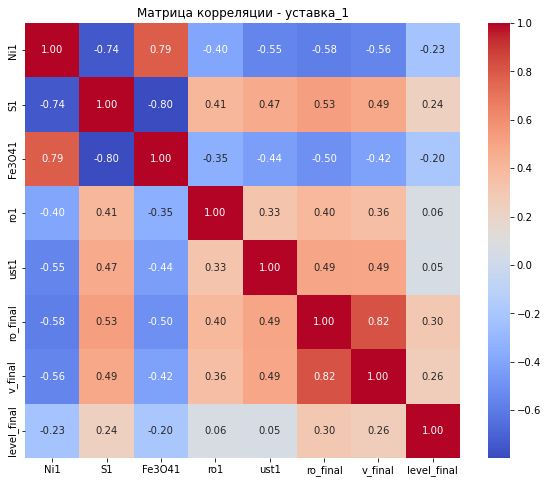

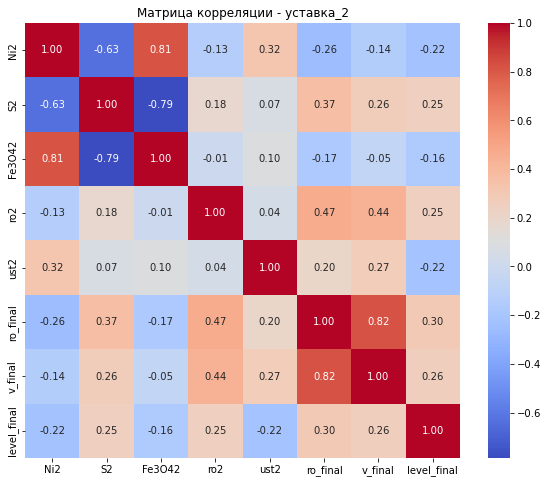

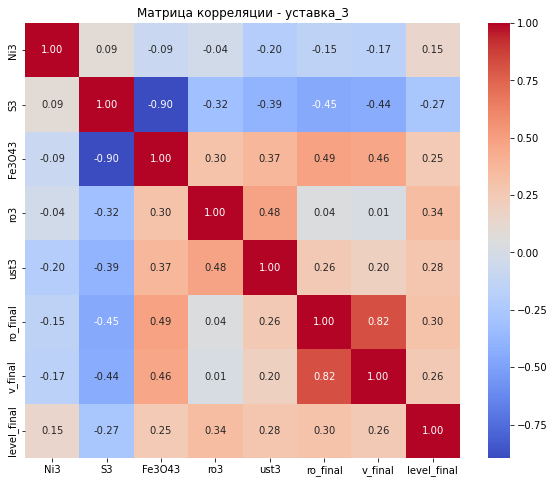

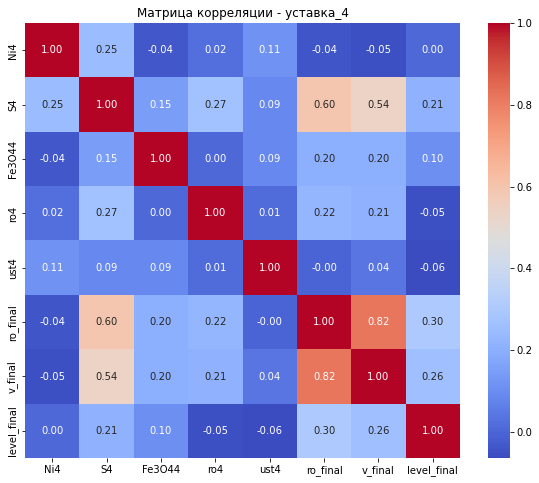

In [92]:
matrix1 = df1[['Ni1', 'S1', 'Fe3O41', 'ro1', 'ust1', 'ro_final', 'v_final', 'level_final']].corr()
matrix2 = df1[['Ni2', 'S2', 'Fe3O42', 'ro2', 'ust2', 'ro_final', 'v_final', 'level_final']].corr()
matrix3 = df1[['Ni3', 'S3', 'Fe3O43', 'ro3', 'ust3', 'ro_final', 'v_final', 'level_final']].corr()
matrix4 = df1[['Ni4', 'S4', 'Fe3O44', 'ro4', 'ust4', 'ro_final', 'v_final', 'level_final']].corr()

plt.figure(figsize=(10, 8)) 
sns.heatmap(matrix1, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Матрица корреляции - уставка_1')
plt.show()

plt.figure(figsize=(10, 8)) 
sns.heatmap(matrix2, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Матрица корреляции - уставка_2')
plt.show()

plt.figure(figsize=(10, 8)) 
sns.heatmap(matrix3, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Матрица корреляции - уставка_3')
plt.show()

plt.figure(figsize=(10, 8)) 
sns.heatmap(matrix4, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Матрица корреляции - уставка_4')
plt.show()


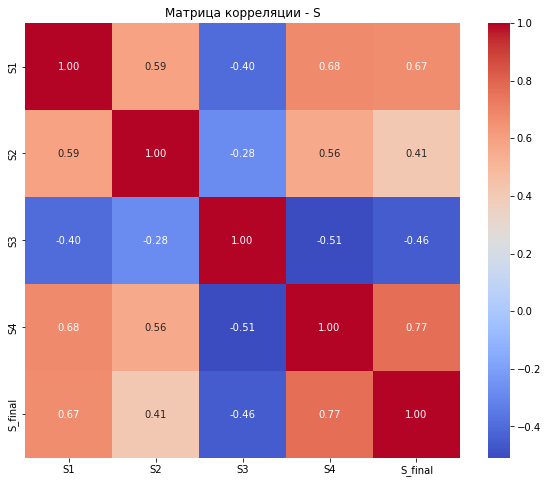

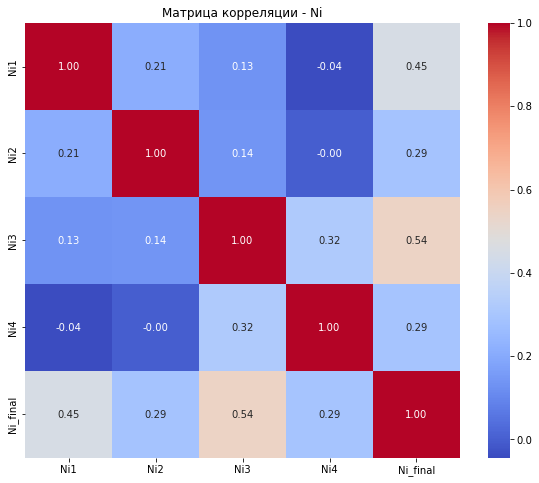

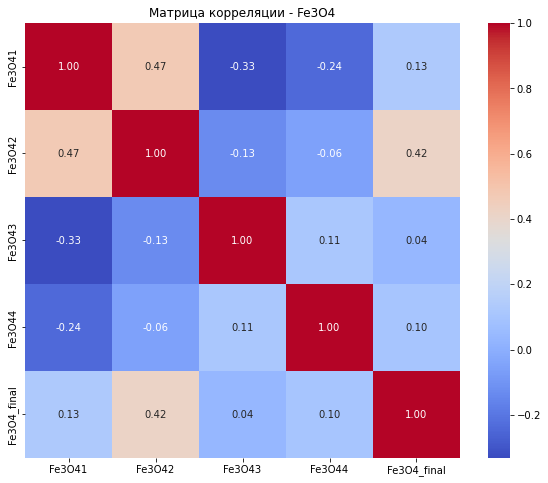

In [97]:
matrix5 = df1[['S1', 'S2', 'S3', 'S4', 'S_final']].corr()
matrix6 = df1[['Ni1', 'Ni2', 'Ni3','Ni4', 'Ni_final']].corr()
matrix7 = df1[['Fe3O41', 'Fe3O42', 'Fe3O43', 'Fe3O44', 'Fe3O4_final']].corr()

plt.figure(figsize=(10, 8)) 
sns.heatmap(matrix5, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Матрица корреляции - S')
plt.show()


plt.figure(figsize=(10, 8)) 
sns.heatmap(matrix6, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Матрица корреляции - Ni')
plt.show()


plt.figure(figsize=(10, 8)) 
sns.heatmap(matrix7, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Матрица корреляции - Fe3O4')
plt.show()

Вывод: Заметна отрицательная корреляция между веществами в одной уставке, что ожидаемо.

### 4) Анализ ошибочных измерений плотностей

In [114]:
ro1_err = data1[(data1['ro1'] < 1.0) | (data1['ro1'] > 2.5)]
ro2_err = data1[(data1['ro2'] < 1.0) | (data1['ro2'] > 2.5)]
ro3_err = data1[(data1['ro3'] < 1.0) | (data1['ro3'] > 2.5)]
ro4_err = data1[(data1['ro4'] < 1.0) | (data1['ro4'] > 2.5)]
ro_final_err = data1[(data1['ro_final'] < 1.0) | (data1['ro_final'] > 2.5)]

Также, посмотрим на распределение количества плотностей по датам, вне заданного диапазона.

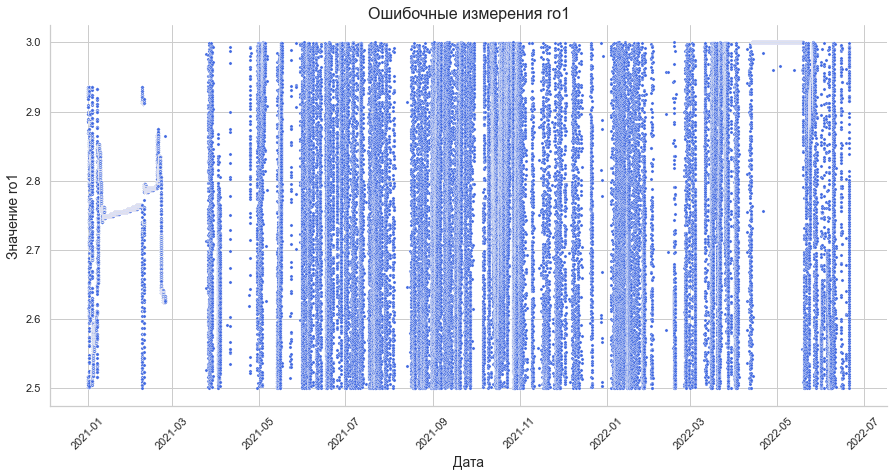

In [102]:
plt.figure(figsize=(15, 7))
sns.set(style="whitegrid")
scatter = sns.scatterplot(data=ro1_err, x="DateTime", y="ro1", color='royalblue', s=10) 
plt.title('Ошибочные измерения ro1', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Значение ro1', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
sns.despine()
plt.show()

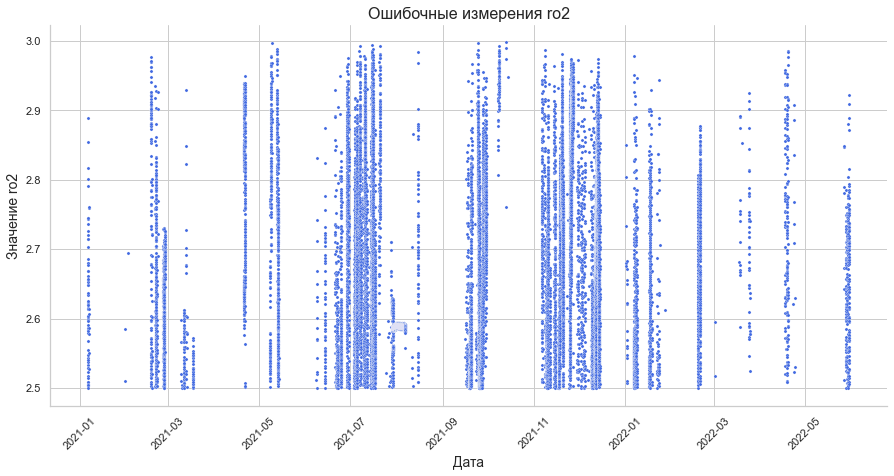

In [103]:
plt.figure(figsize=(15, 7))
sns.set(style="whitegrid")
scatter = sns.scatterplot(data=ro2_err, x="DateTime", y="ro2", color='royalblue', s=10) 
plt.title('Ошибочные измерения ro2', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Значение ro2', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
sns.despine()
plt.show()

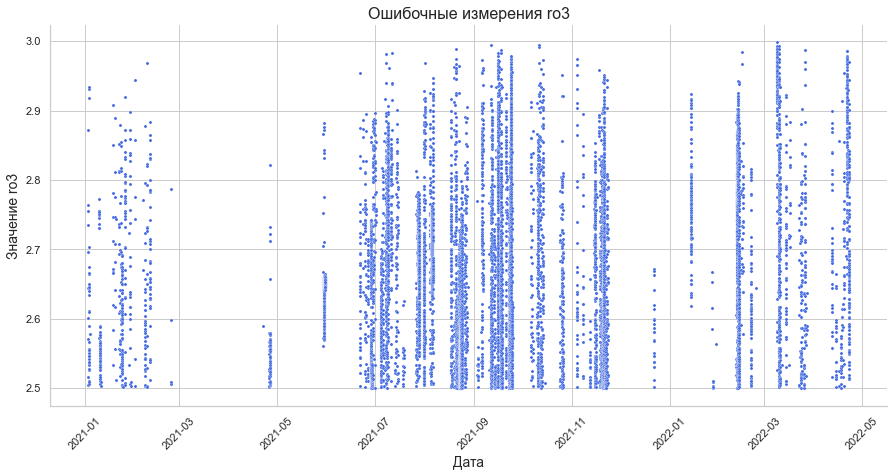

In [104]:
plt.figure(figsize=(15, 7))
sns.set(style="whitegrid")
scatter = sns.scatterplot(data=ro3_err, x="DateTime", y="ro3", color='royalblue', s=10) 
plt.title('Ошибочные измерения ro3', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Значение ro3', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
sns.despine()
plt.show()

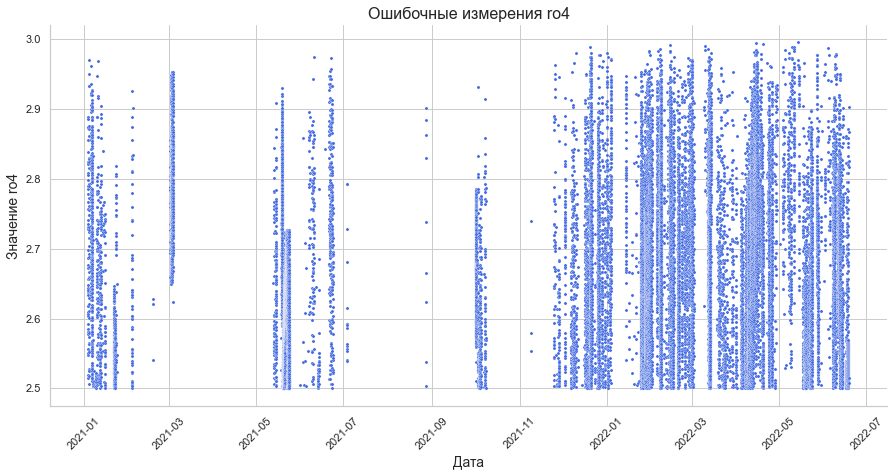

In [116]:
plt.figure(figsize=(15, 7))
sns.set(style="whitegrid")
scatter = sns.scatterplot(data=ro4_err, x="DateTime", y="ro4", color='royalblue', s=10) 
plt.title('Ошибочные измерения ro4', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Значение ro4', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
sns.despine()
plt.show()

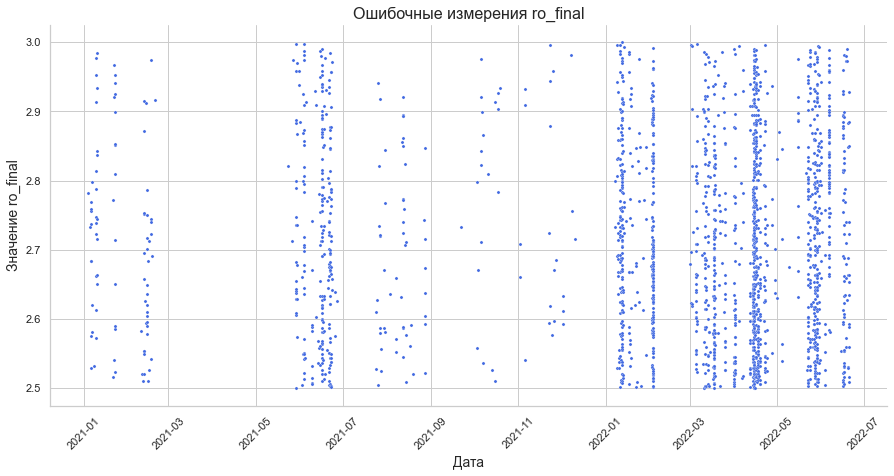

In [105]:
plt.figure(figsize=(15, 7))
sns.set(style="whitegrid")
scatter = sns.scatterplot(data=ro_final_err, x="DateTime", y="ro_final", color='royalblue', s=10) 
plt.title('Ошибочные измерения ro_final', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Значение ro_final', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
sns.despine()
plt.show()

Вывод: Распределение данных дискретное, возможно, есть значение в таком распределении.

### 5) Анализ выбросов данных

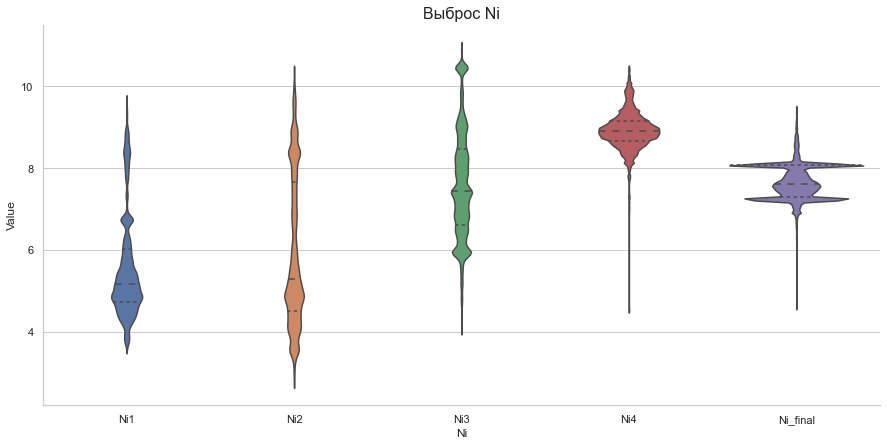

In [146]:
plt.figure(figsize=(15, 7))
plt.title('Выброс Ni', fontsize=16)
df_ = pd.melt(df1, value_vars=['Ni1', 'Ni2', 'Ni3', 'Ni4', 'Ni_final'], var_name='Ni', value_name='Value')
sns.violinplot(x='Ni', y='Value', data=df_, split=True, gap=.1, inner="quart")
sns.despine()
plt.show()

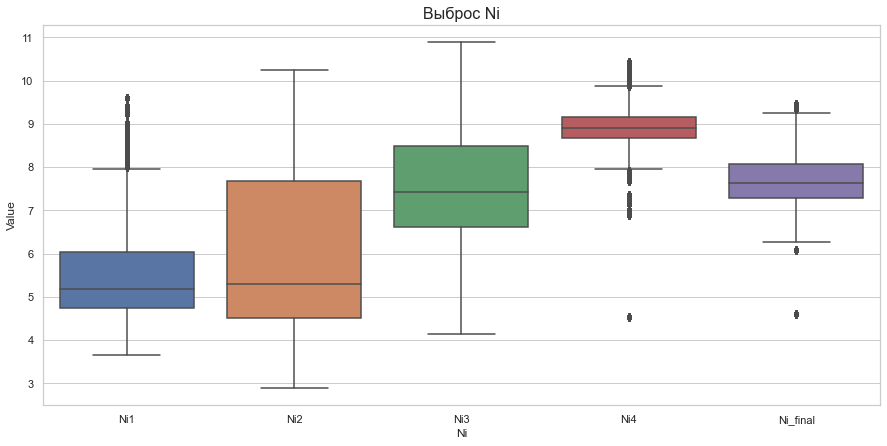

In [147]:
plt.figure(figsize=(15, 7))
plt.title('Выброс Ni', fontsize=16)
sns.boxplot(x='Ni', y='Value', data=df_)
plt.show()

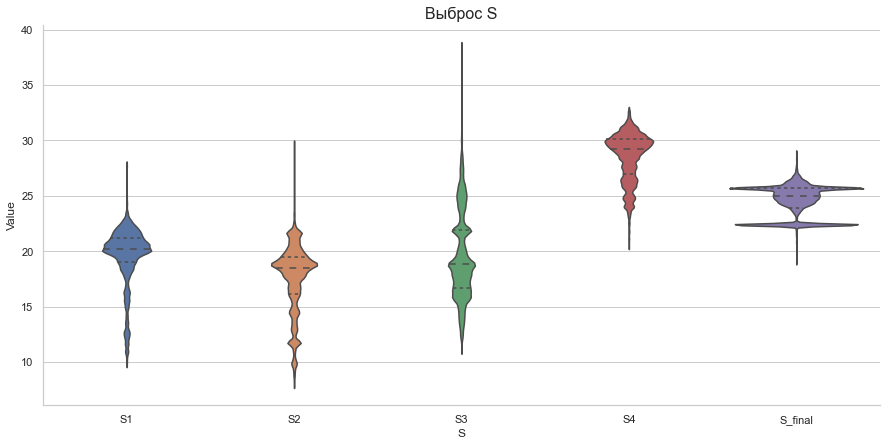

In [148]:
plt.figure(figsize=(15, 7))
plt.title('Выброс S', fontsize=16)
df_ = pd.melt(df1, value_vars=['S1', 'S2', 'S3', 'S4', 'S_final'], var_name='S', value_name='Value')
sns.violinplot(x='S', y='Value', data=df_, split=True, gap=.1, inner="quart")
sns.despine()
plt.show()

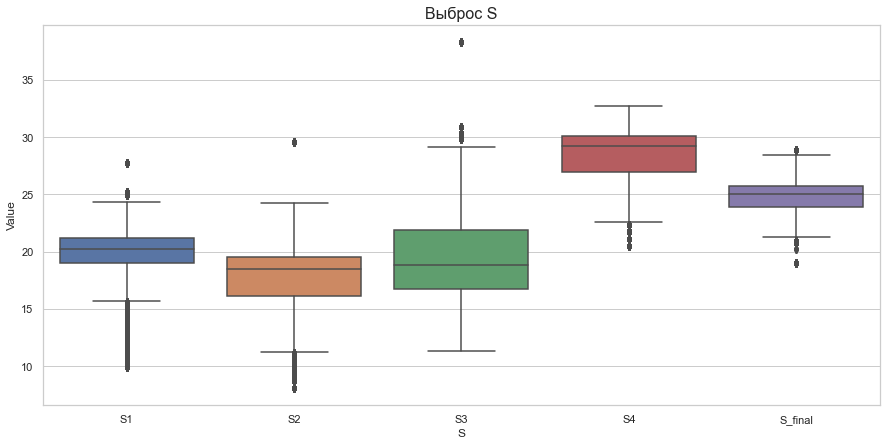

In [149]:
plt.figure(figsize=(15, 7))
plt.title('Выброс S', fontsize=16)
sns.boxplot(x='S', y='Value', data=df_)
plt.show()

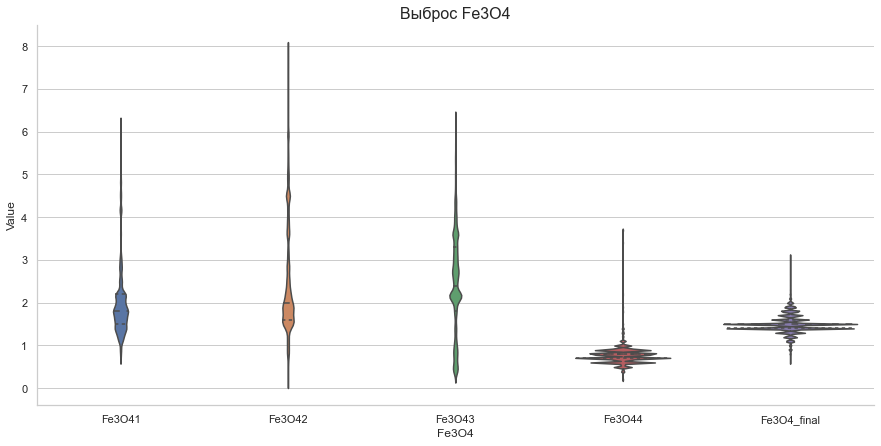

In [155]:
plt.figure(figsize=(15, 7))
plt.title('Выброс Fe3O4', fontsize=16)
df_ = pd.melt(df1, value_vars=['Fe3O41', 'Fe3O42', 'Fe3O43', 'Fe3O44','Fe3O4_final'], var_name='Fe3O4', value_name='Value')
sns.violinplot(x='Fe3O4', y='Value', data=df_, split=True, gap=.1, inner="quart")
sns.despine()
plt.show()

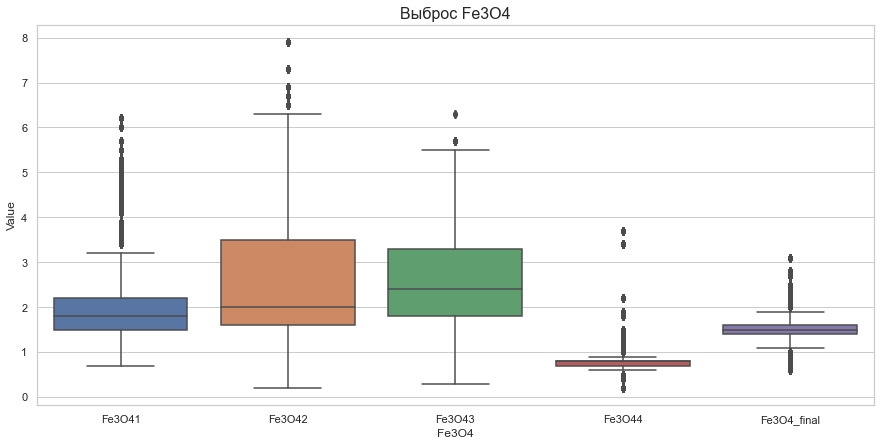

In [156]:
plt.figure(figsize=(15, 7))
plt.title('Выброс Fe3O4', fontsize=16)
sns.boxplot(x='Fe3O4', y='Value', data=df_)
plt.show()

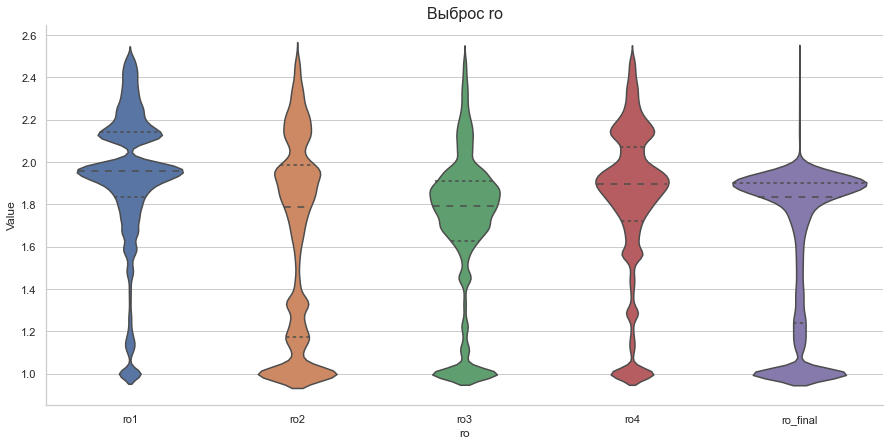

In [157]:
plt.figure(figsize=(15, 7))
plt.title('Выброс ro', fontsize=16)
df_ = pd.melt(df1, value_vars=['ro1', 'ro2', 'ro3', 'ro4', 'ro_final'], var_name='ro', value_name='Value')
sns.violinplot(x='ro', y='Value', data=df_, split=True, gap=.1, inner="quart")
sns.despine()
plt.show()

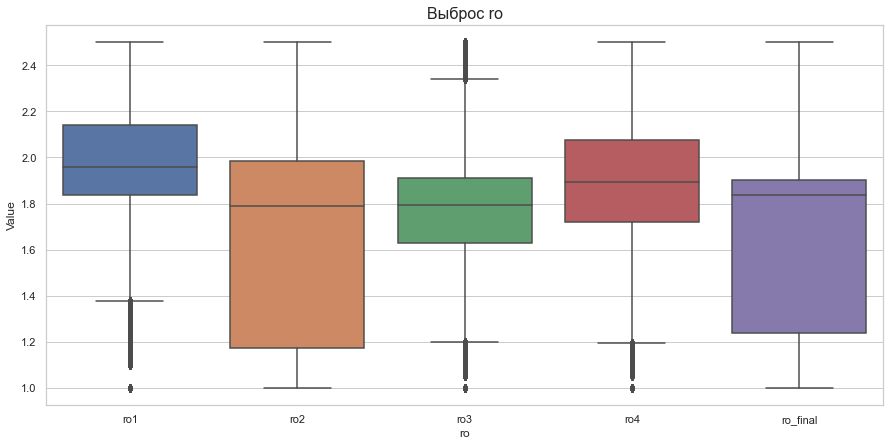

In [158]:
plt.figure(figsize=(15, 7))
plt.title('Выброс ro', fontsize=16)
sns.boxplot(x='ro', y='Value', data=df_)
plt.show()

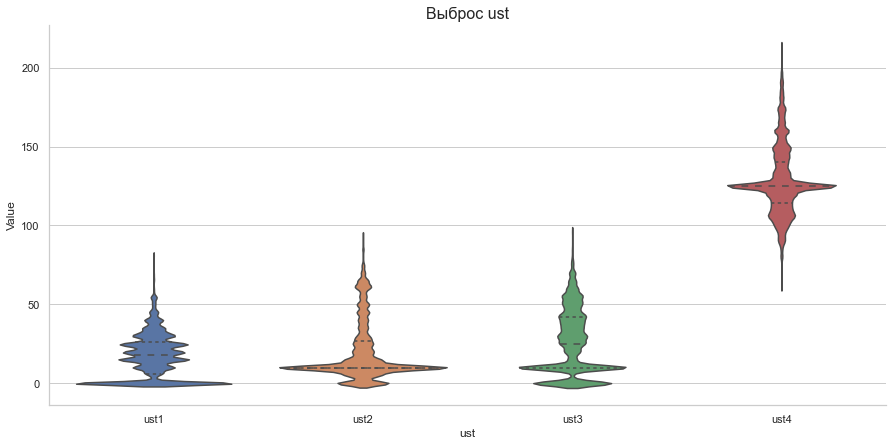

In [159]:
plt.figure(figsize=(15, 7))
plt.title('Выброс ust', fontsize=16)
df_ = pd.melt(df1, value_vars=['ust1', 'ust2', 'ust3', 'ust4'], var_name='ust', value_name='Value')
sns.violinplot(x='ust', y='Value', data=df_, split=True, gap=.1, inner="quart")
sns.despine()
plt.show()

Вывод: Выбросы заметны в данных.

* Построим графики по группам

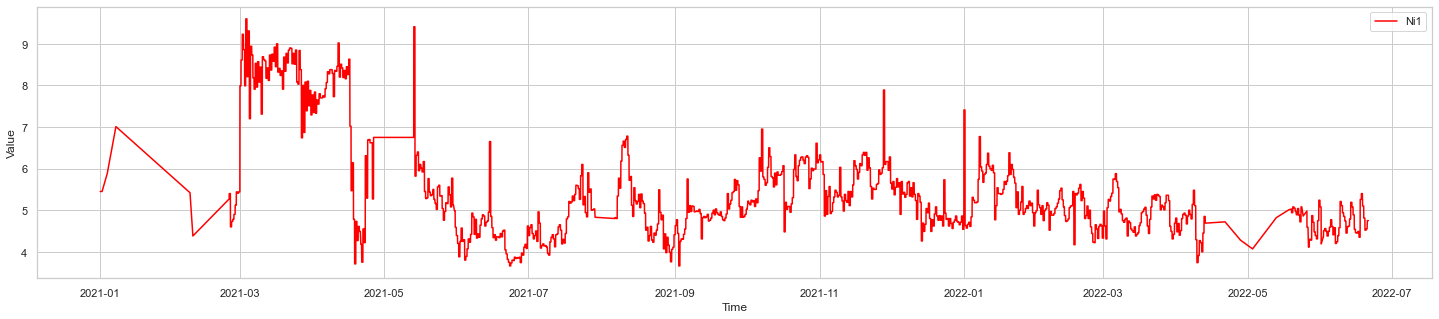

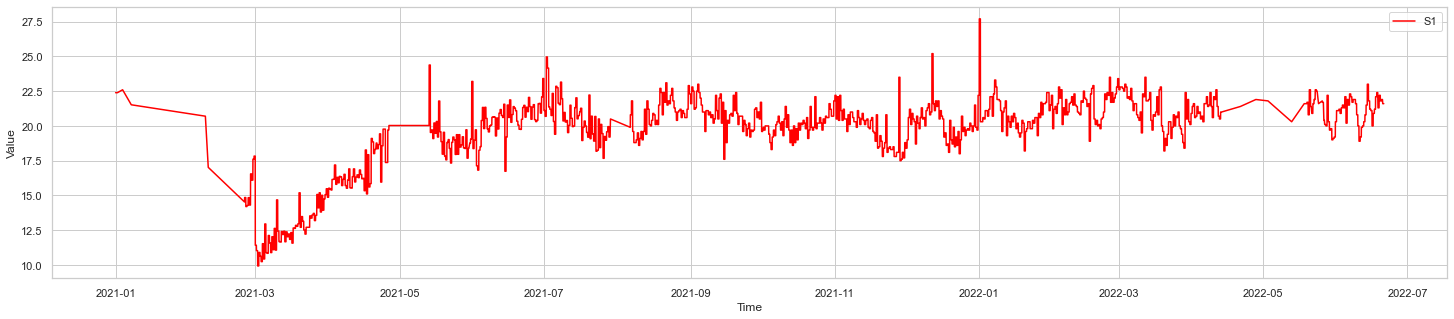

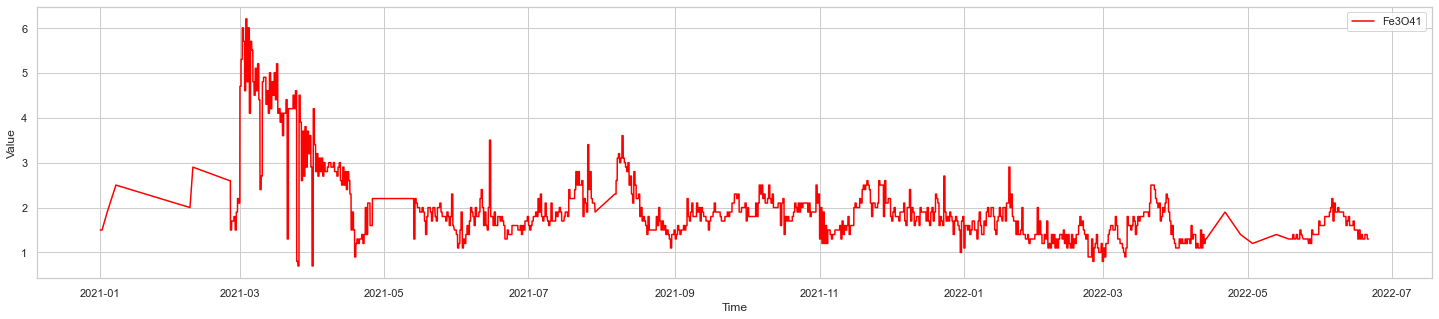

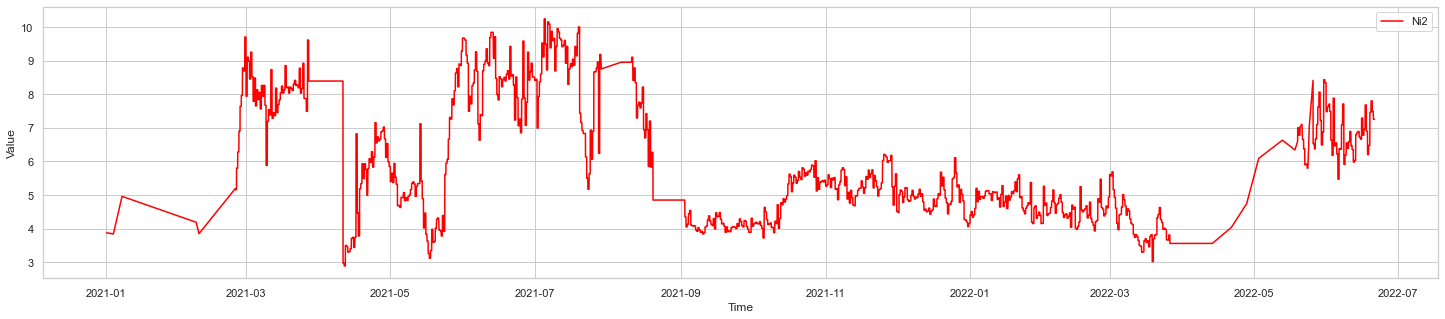

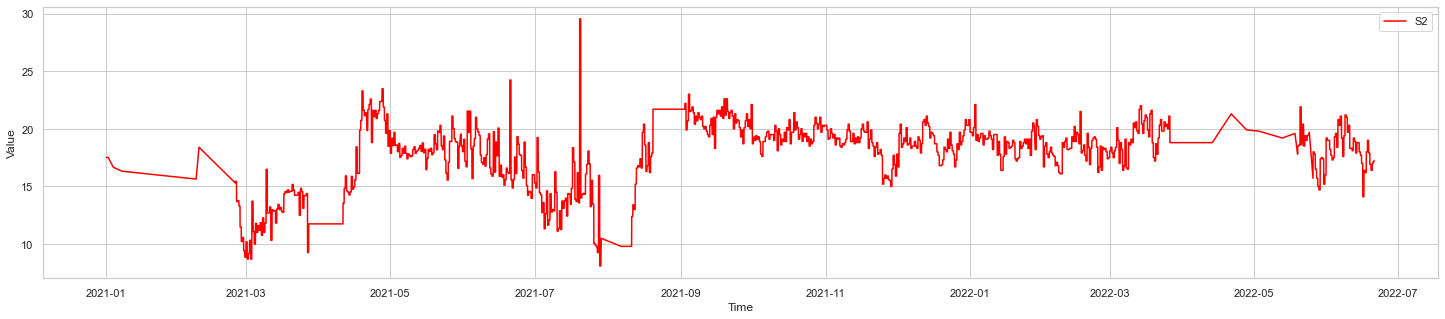

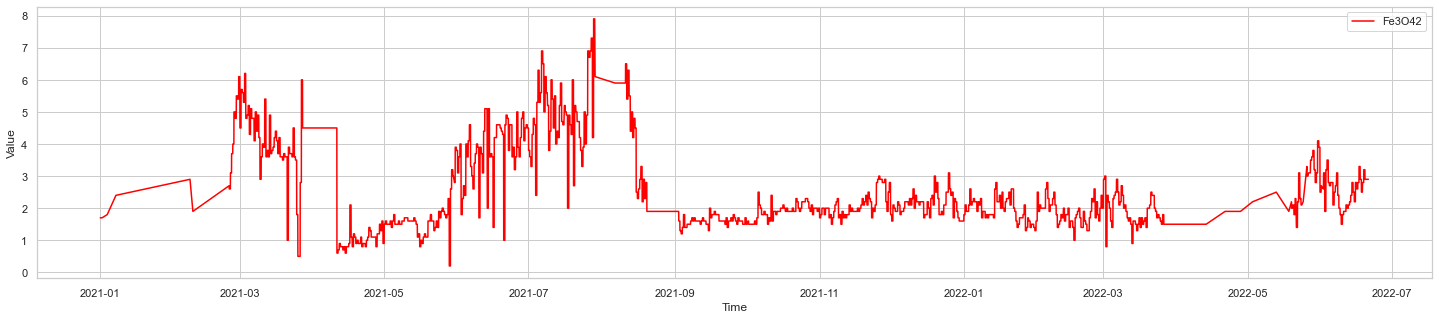

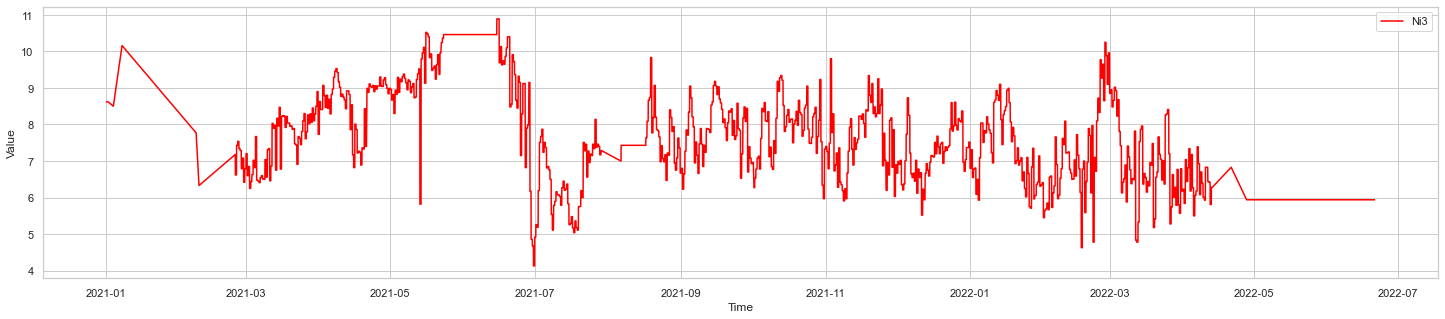

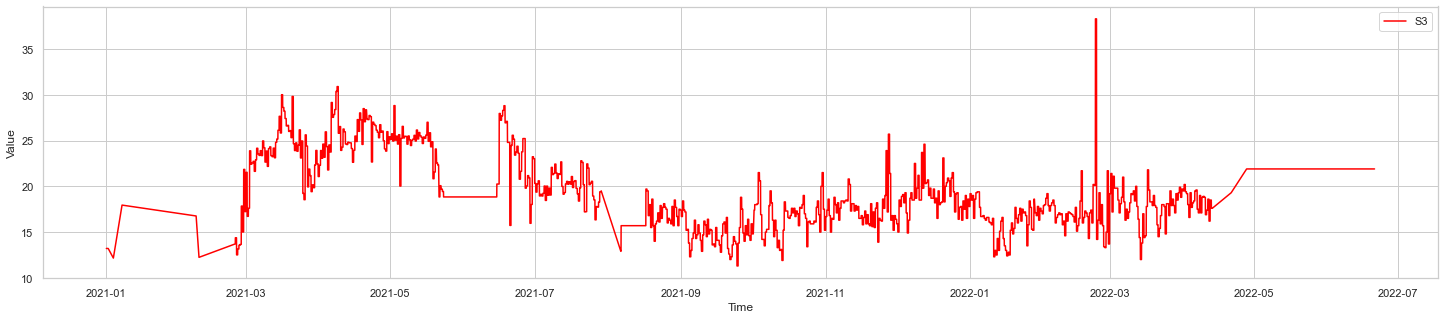

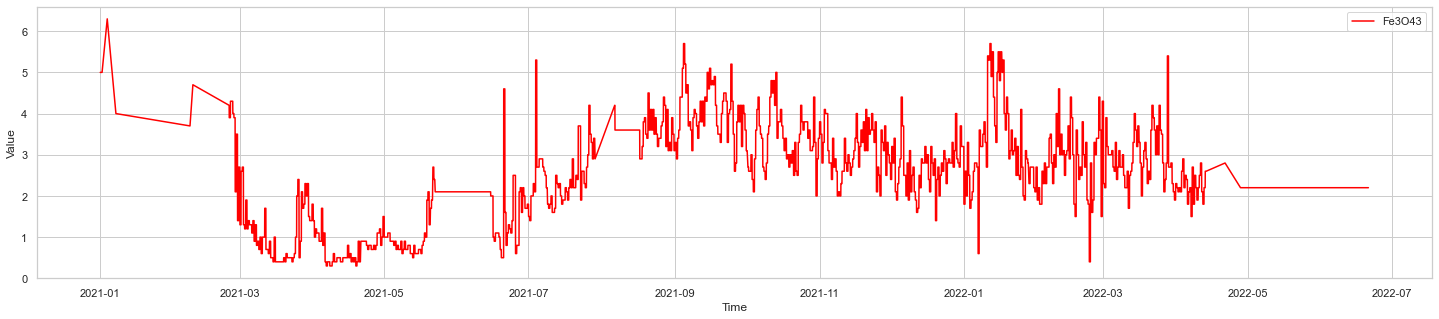

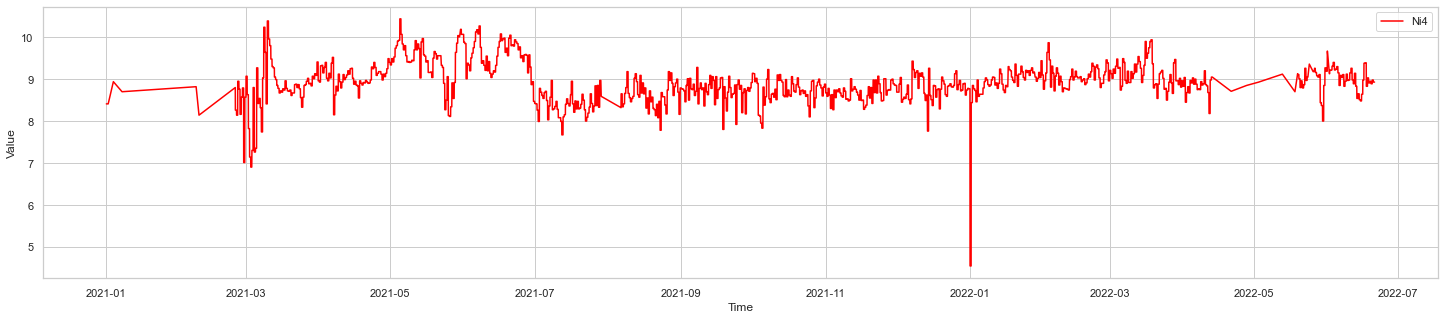

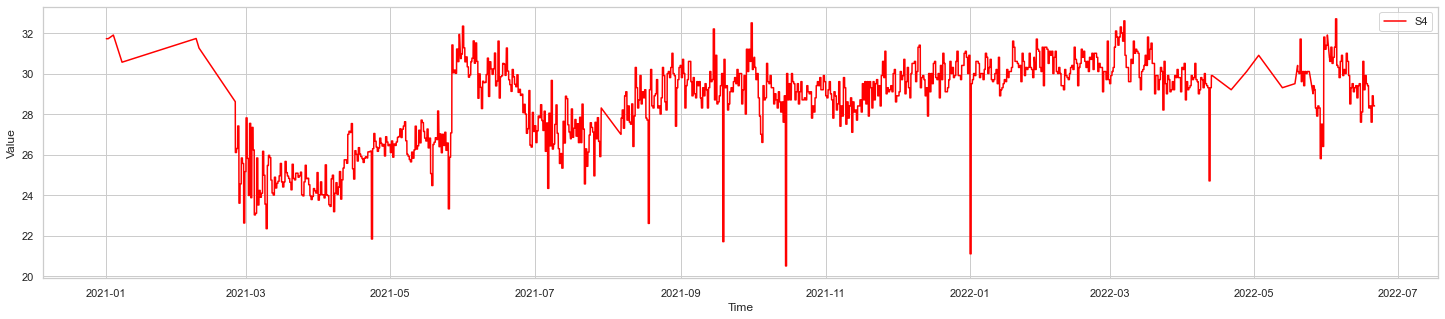

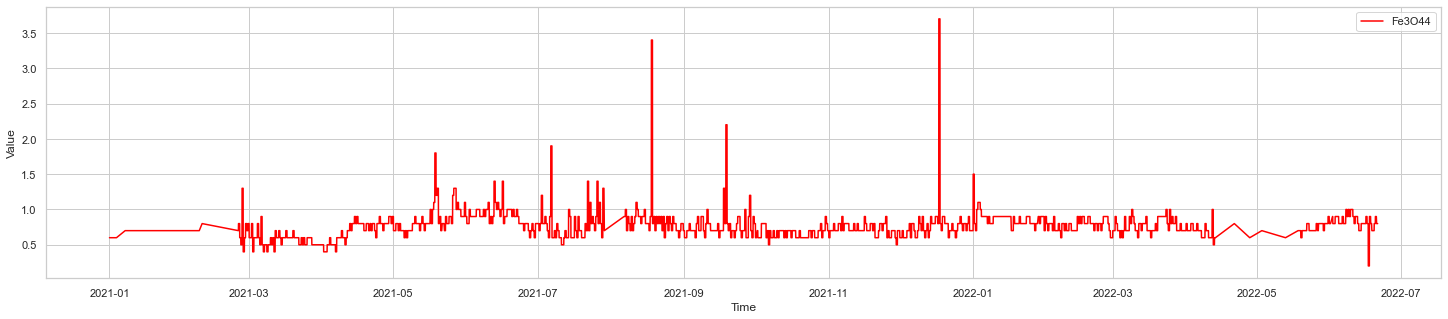

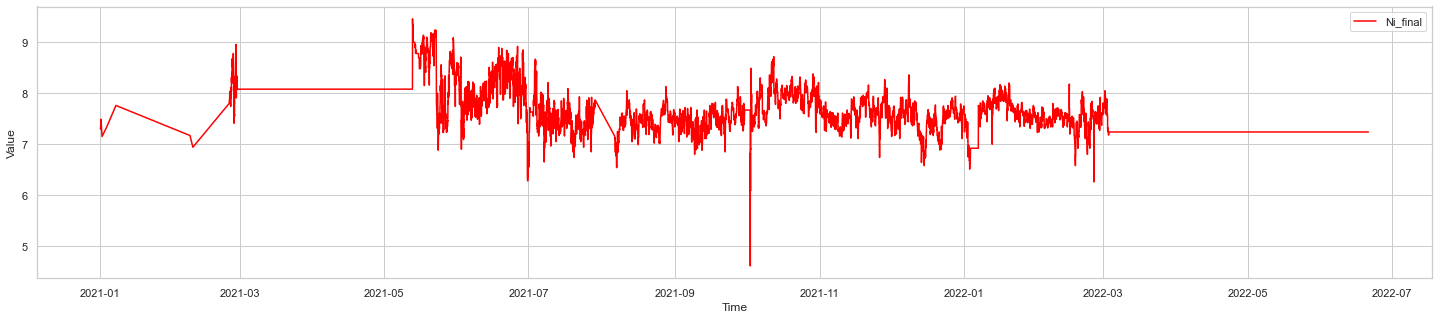

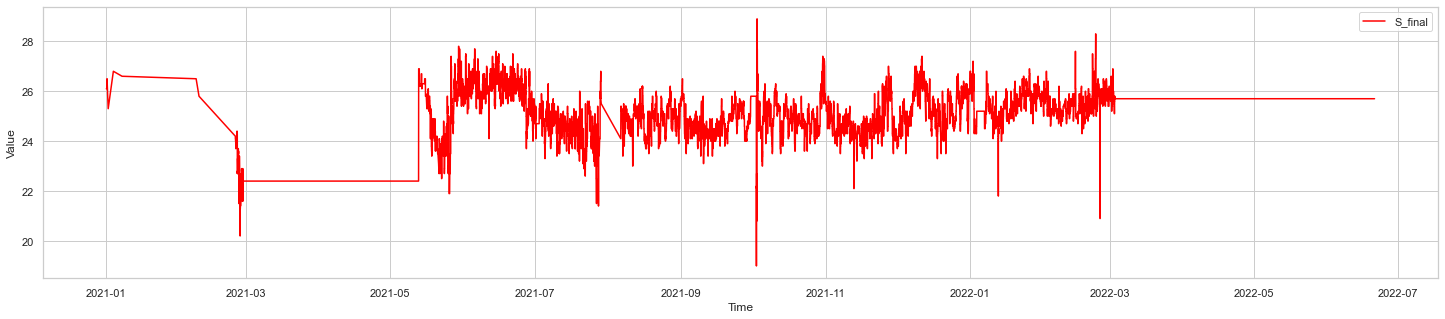

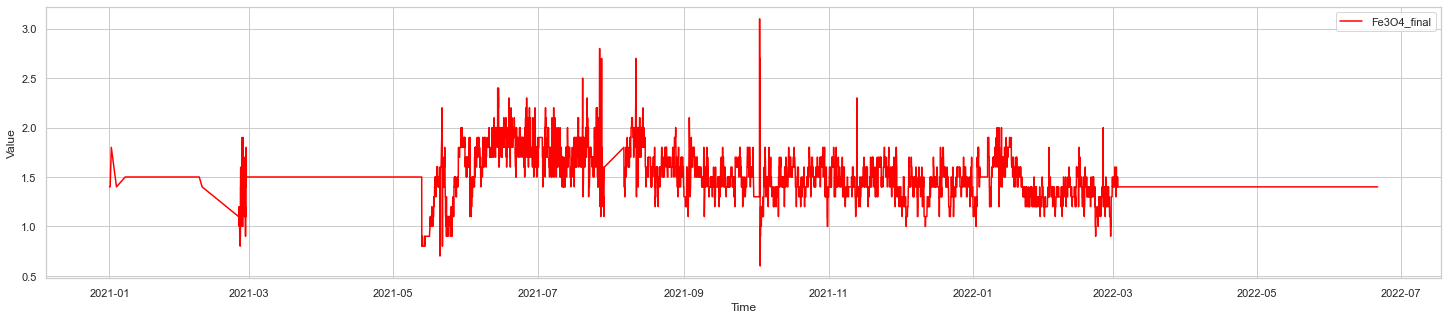

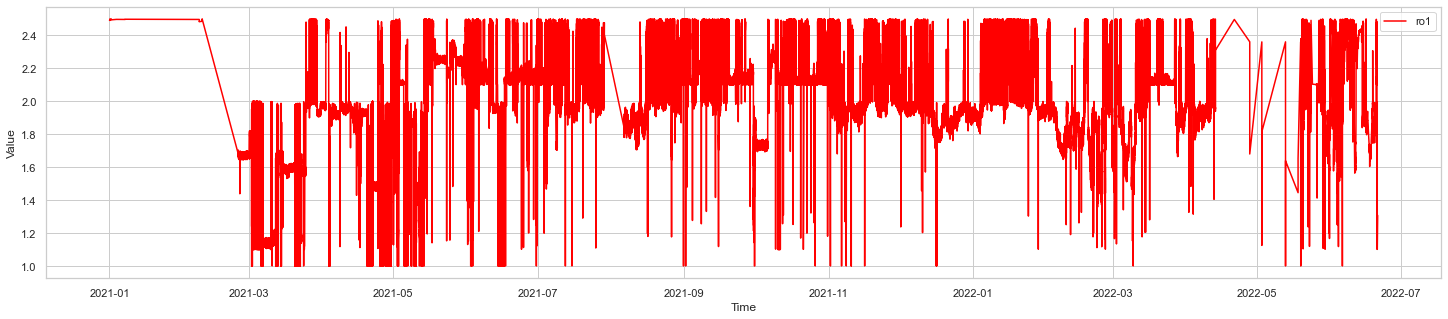

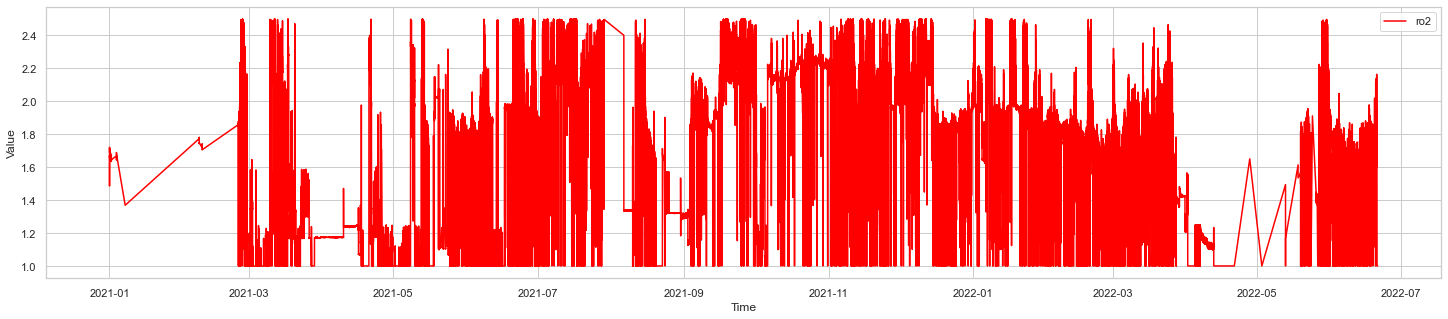

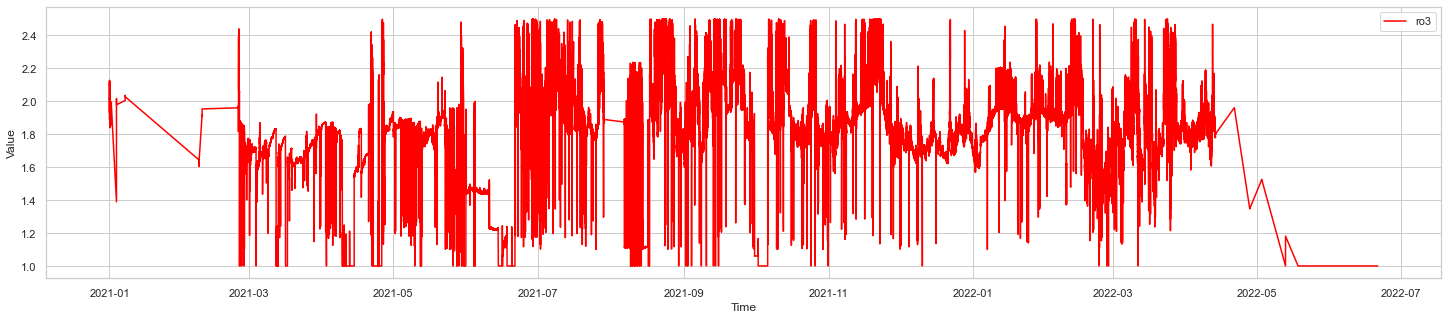

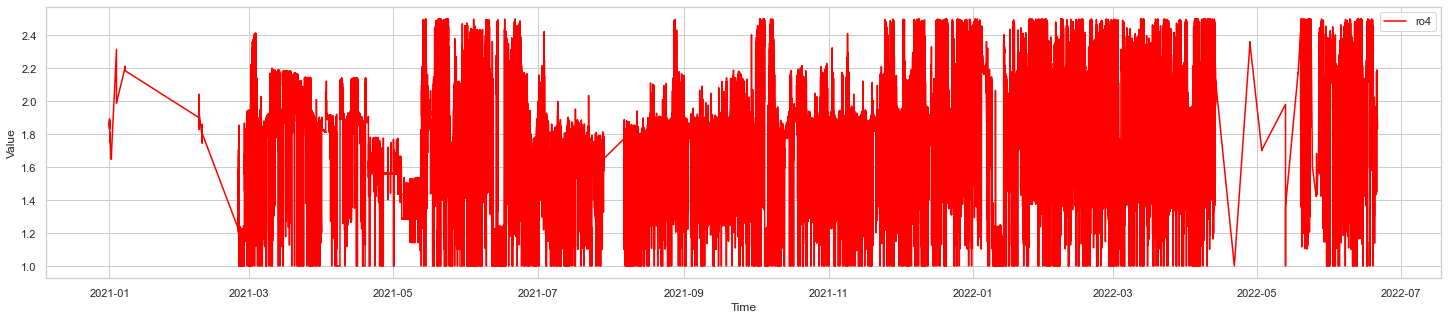

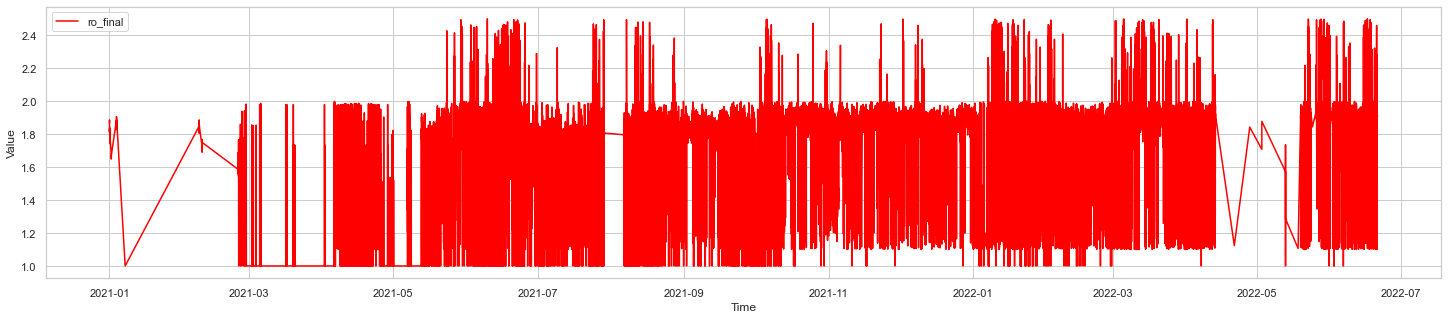

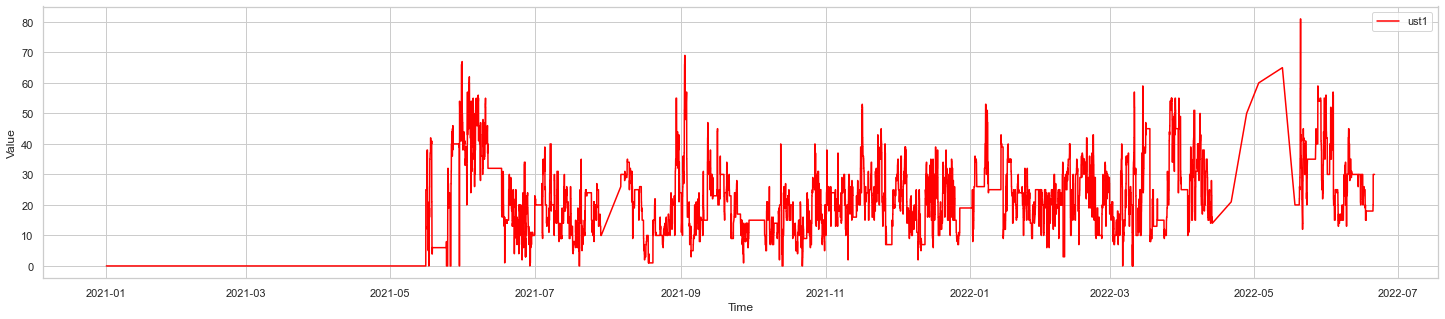

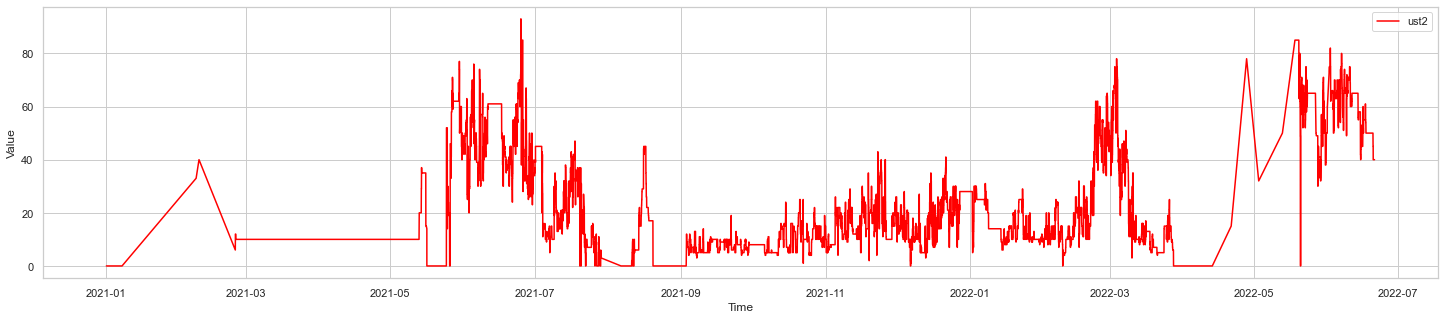

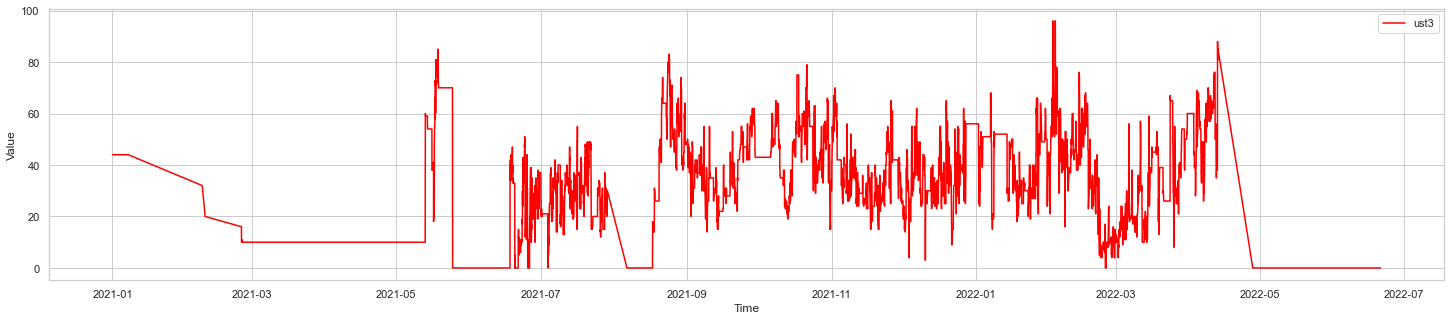

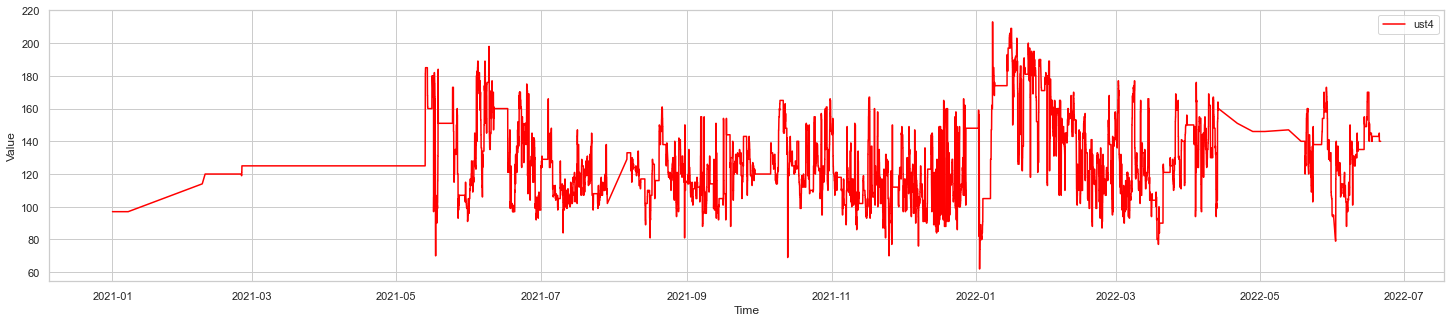

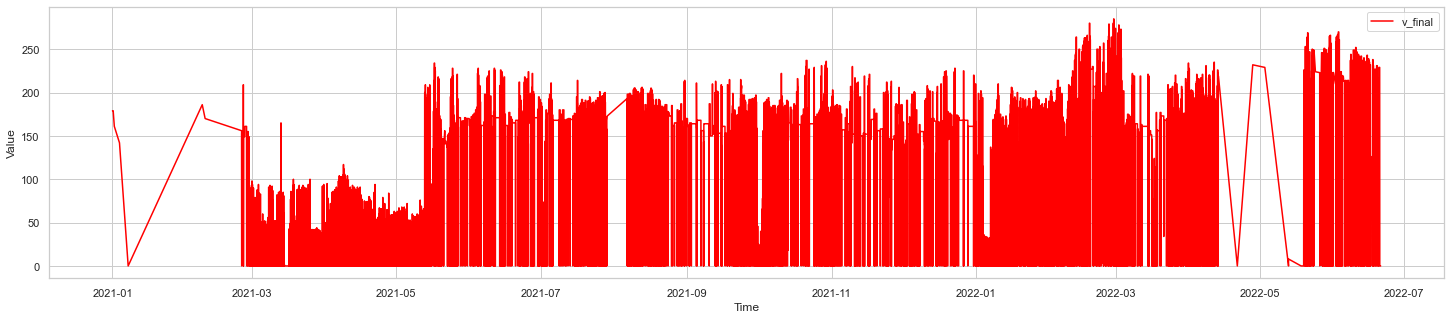

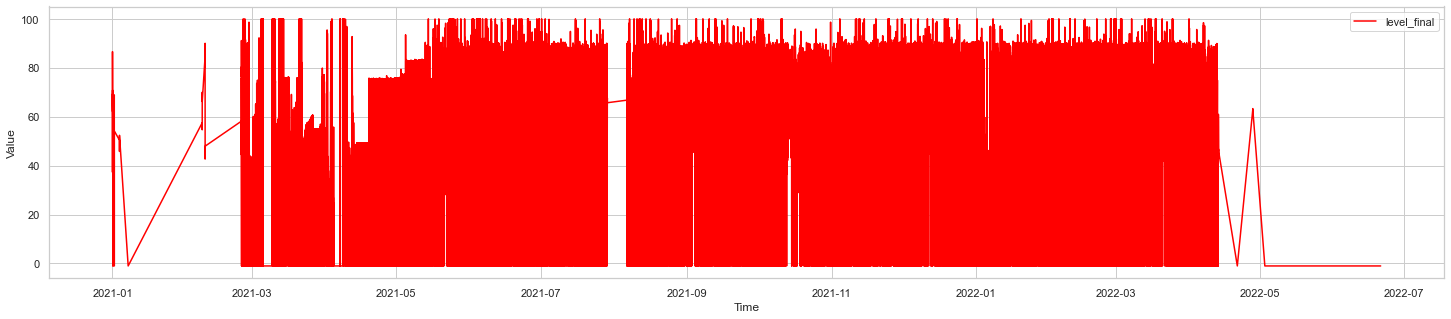

In [170]:
for column in df1.columns[1:]:
    plt.figure(figsize=(25, 5))
    plt.plot(df1['DateTime'], df1[column], label=column, color = 'red')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    plt.show()

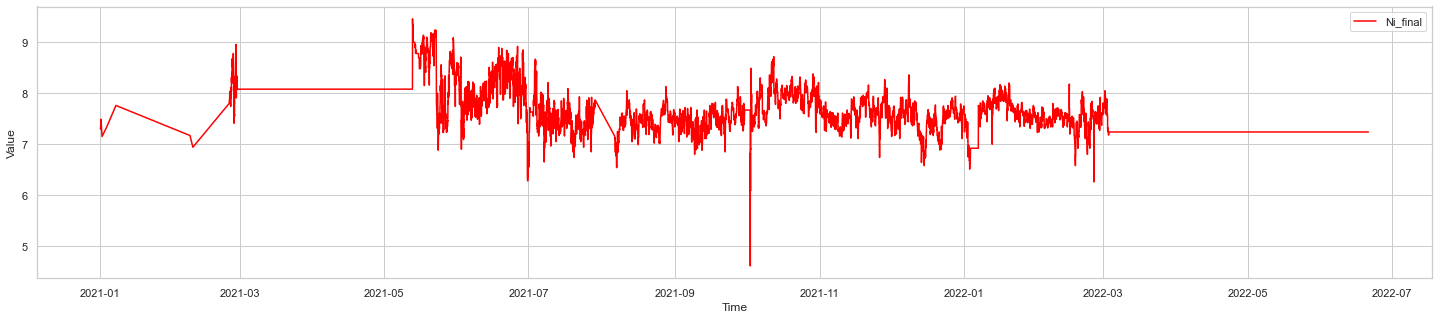

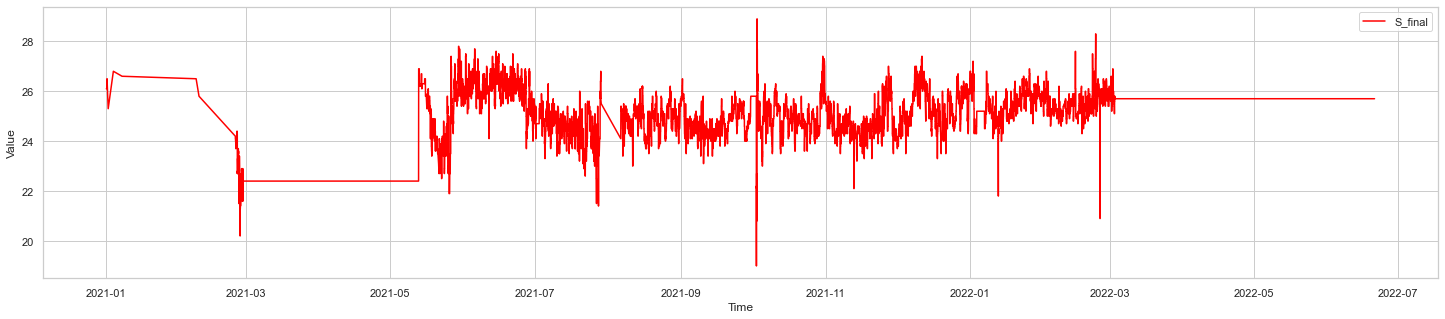

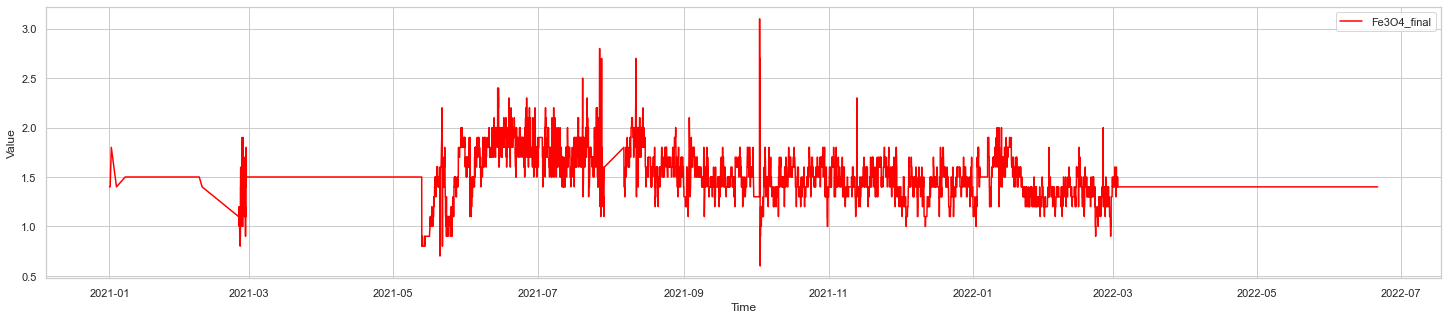

In [258]:
for column in ['Ni_final','S_final','Fe3O4_final']:
    plt.figure(figsize=(25, 5))
    plt.plot(df1['DateTime'], df1[column], label=column, color = 'red')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    plt.show()

С графиков можно увидеть что процесс является некорректным в начале и уходит на константу раньше чем измерения закончились.
Поэтому рассмотрим только данные в диапазоне дат 2021-06 / 2022-03.

In [158]:
start_date = pd.to_datetime('2021-06')
end_date = pd.to_datetime('2022-03')

df1 = df1[(df1['DateTime'] >= start_date) & (df1['DateTime'] <= end_date)]

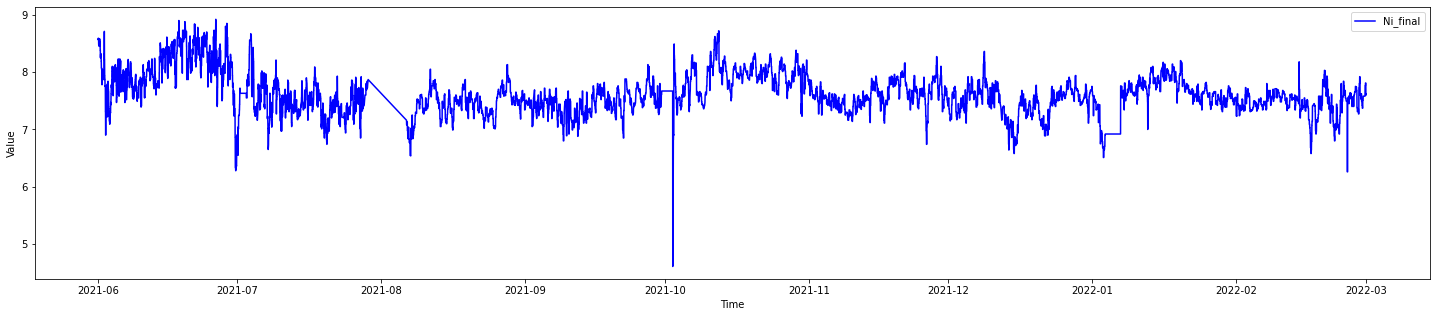

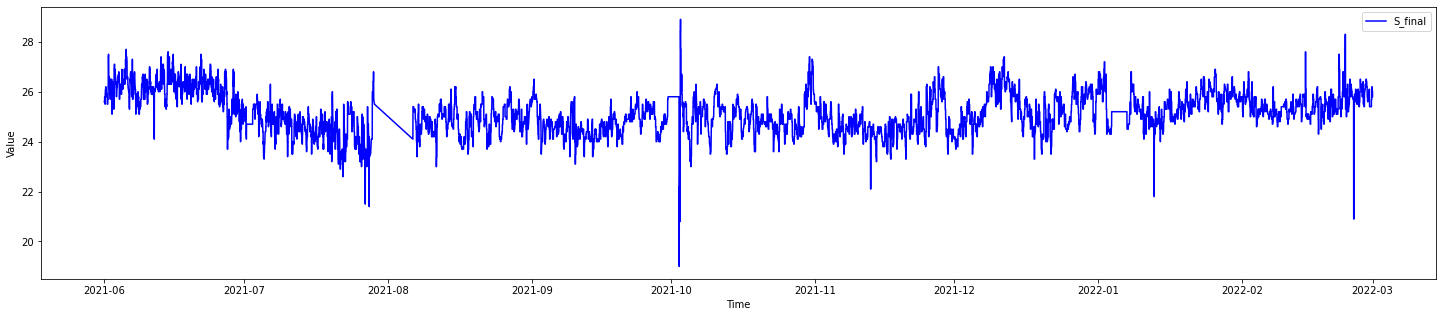

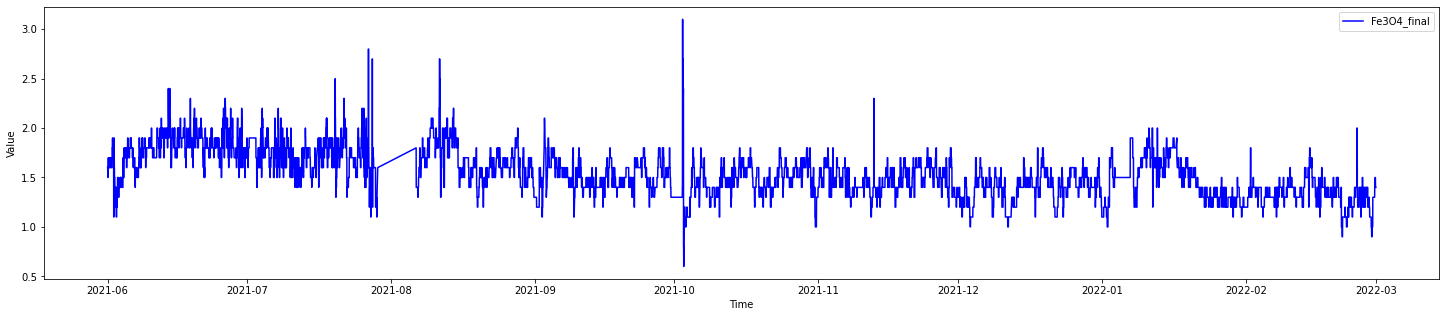

In [159]:
for column in ['Ni_final','S_final','Fe3O4_final']:
    plt.figure(figsize=(25, 5))
    plt.plot(df1['DateTime'], df1[column], label=column, color = 'blue')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    plt.show()

Также, на дату 2021-10 замечен скачок в данных.

## Этап 2. Моделирование

### 1) Математическая модель

Общий поток $Q$:

$$ Q = q_1 + q_2 + q_3 + q_4 $$

Финальная концентрация $Ni$:

$$ Ni_{{final}} = \frac{q_1∙Ni_1 + q_2∙Ni_2 + q_3∙Ni_3 + q_4∙Ni_4}{Q} $$

Финальная концентрация $S$:

$$ S_{{final}} = \frac{q_1∙S_1 + q_2∙S_2 + q_3∙S_3 + q_4∙S_4}{Q} $$

Финальная концентрация $Fe_3O_4$:

$$ Fe3O4_{{final}} = \frac{q_1∙Fe3O4_1 + q_2∙Fe3O4_2 + q_3∙Fe3O4_3 + q_4∙Fe3O4_4}{Q} $$

In [160]:
def math_model_Ni(data):
    
    Q_sum = data['ust1'] + data['ust2'] + data['ust3'] + data['ust4']
    Ni_pred = (data['Ni1']*data['ust1'] + data['Ni2']*data['ust2'] + data['Ni3']*data['ust3'] + data['Ni4']*data['ust4']) / Q_sum
    Ni = pd.concat([Ni_pred,data['Ni_final']], axis = 1)
    Ni = pd.DataFrame({'Ni_pred': Ni_pred, 'Ni_final': data['Ni_final'], 'DateTime': data['DateTime']})
    Ni.columns = ['Ni_pred','Ni_final', 'DateTime']
    
    return Ni

In [161]:
def math_model_S(data):
    
    Q_sum = data['ust1'] + data['ust2'] + data['ust3'] + data['ust4']
    S_pred = (data['S1']*data['ust1'] + data['S2']*data['ust2'] + data['S3']*data['ust3'] + data['S4']*data['ust4']) / Q_sum
    S = pd.DataFrame({'S_pred': S_pred, 'S_final': data['S_final'], 'DateTime': data['DateTime']})
    S.columns = ['S_pred','S_final', 'DateTime']
    
    return S

In [162]:
def math_model_Fe3O4(data):
    
    Q_sum = data['ust1'] + data['ust2'] + data['ust3'] + data['ust4']
    Fe3O4_pred = (data['Fe3O41']*data['ust1'] + data['Fe3O42']*data['ust2'] + data['Fe3O43']*data['ust3'] + data['Fe3O44']*data['ust4']) / Q_sum
    Fe3O4 = pd.DataFrame({'Fe3O4_pred': Fe3O4_pred, 'Fe3O4_final': data['Fe3O4_final'], 'DateTime': data['DateTime']})
    Fe3O4.columns = ['Fe3O4_pred','Fe3O4_final','DateTime']
    
    return Fe3O4

### 2) Калибровка 

Используем известные нам измерения финальных параметров, чтобы с помощью линейной регрессии  откалибровать данные и улучшить модель. 

1)  Ni

In [214]:
Ni_data =  math_model_Ni(df1)
X = Ni_data['Ni_pred'].values.reshape(-1, 1) 
y = Ni_data['Ni_final'].values  

calibration_model_Ni = LinearRegression(fit_intercept=True)  
calibration_model_Ni.fit(X, y)

calibrated_predictions = calibration_model_Ni.predict(X)

mse_before_calibration = mean_squared_error(y, Ni_data['Ni_pred'])
mse_after_calibration = mean_squared_error(y, calibrated_predictions)

print(f'MSE до калибровки: {mse_before_calibration}')
print(f'MSE после калибровки: {mse_after_calibration}')

MSE до калибровки: 0.25562094854752776
MSE после калибровки: 0.07140972404771458


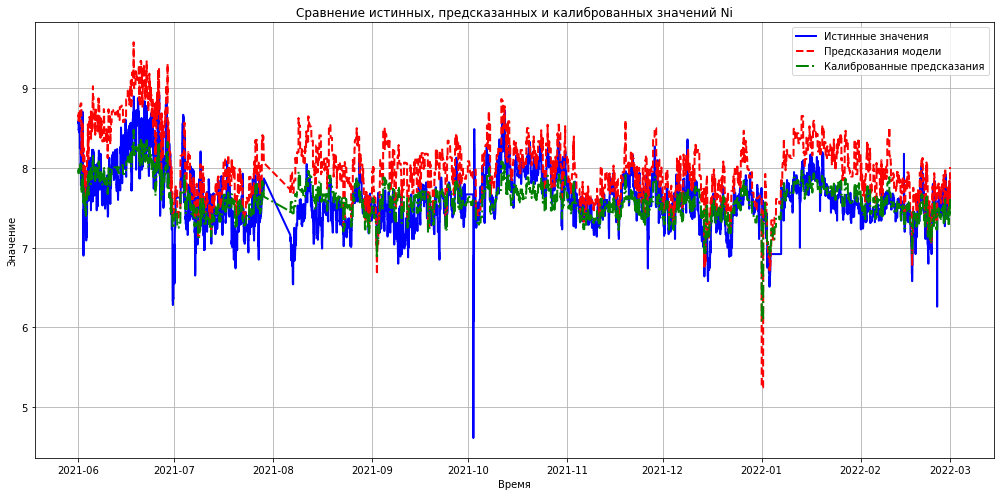

In [164]:
plt.figure(figsize=(14, 7)) 

plt.plot(Ni_data['DateTime'], Ni_data['Ni_final'], label='Истинные значения', color='blue', marker='', linestyle='-', linewidth=2)
plt.plot(Ni_data['DateTime'], Ni_data['Ni_pred'], label='Предсказания модели', color='red', marker='', linestyle='--', linewidth=2)
plt.plot(Ni_data['DateTime'], calibrated_predictions, label='Калиброванные предсказания', color='green', marker='', linestyle='-.', linewidth=2)

plt.xlabel('Время')  
plt.ylabel('Значение')  
plt.title('Сравнение истинных, предсказанных и калиброванных значений Ni') 
plt.legend()  
plt.grid(True)  
plt.tight_layout()  

plt.show()

2) S

In [180]:
S_data =  math_model_S(df1)
X = S_data['S_pred'].values.reshape(-1, 1) 
y = S_data['S_final'].values  

calibration_model_S = LinearRegression(fit_intercept=True)  
calibration_model_S.fit(X, y)

calibrated_predictions = calibration_model_S.predict(X)

mse_before_calibration = mean_squared_error(y, S_data['S_pred'])
mse_after_calibration = mean_squared_error(y, calibrated_predictions)

print(f'MSE до калибровки: {mse_before_calibration}')
print(f'MSE после калибровки: {mse_after_calibration}')

MSE до калибровки: 1.1995007213447517
MSE после калибровки: 0.5547773049477771


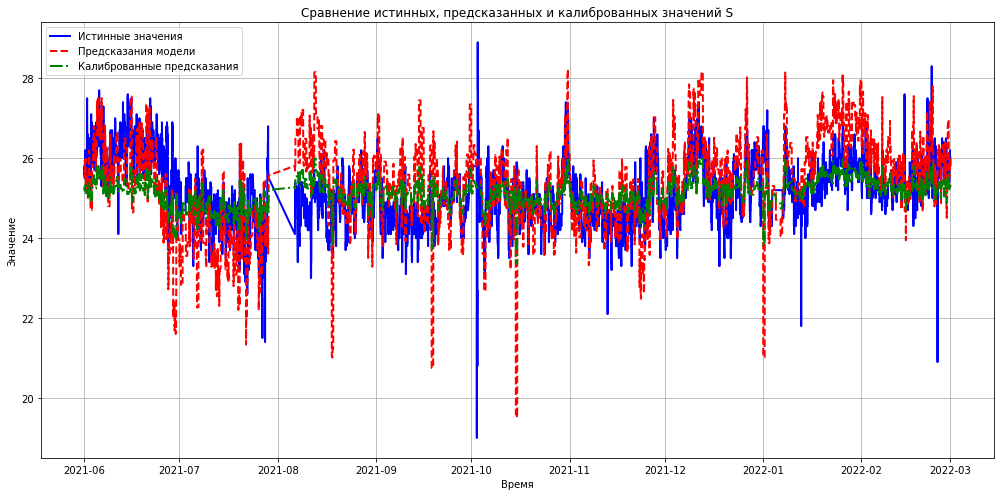

In [166]:
plt.figure(figsize=(14, 7)) 

plt.plot(S_data['DateTime'], S_data['S_final'], label='Истинные значения', color='blue', marker='', linestyle='-', linewidth=2)
plt.plot(S_data['DateTime'], S_data['S_pred'], label='Предсказания модели', color='red', marker='', linestyle='--', linewidth=2)
plt.plot(S_data['DateTime'], calibrated_predictions, label='Калиброванные предсказания', color='green', marker='', linestyle='-.', linewidth=2)

plt.xlabel('Время')  
plt.ylabel('Значение')  
plt.title('Сравнение истинных, предсказанных и калиброванных значений S') 
plt.legend()  
plt.grid(True)  
plt.tight_layout()  

plt.show()

3) Fe3O4

In [167]:
Fe3O4_data =  math_model_Fe3O4(df1)
X = Fe3O4_data['Fe3O4_pred'].values.reshape(-1, 1) 
y = Fe3O4_data['Fe3O4_final'].values  

calibration_model_Fe3O4 = LinearRegression(fit_intercept=True)  
calibration_model_Fe3O4.fit(X, y)

calibrated_predictions = calibration_model_Fe3O4.predict(X)

mse_before_calibration = mean_squared_error(y, Fe3O4_data['Fe3O4_pred'])
mse_after_calibration = mean_squared_error(y, calibrated_predictions)

print(f'MSE до калибровки: {mse_before_calibration}')
print(f'MSE после калибровки: {mse_after_calibration}')

MSE до калибровки: 0.0680653381114451
MSE после калибровки: 0.04326481288411678


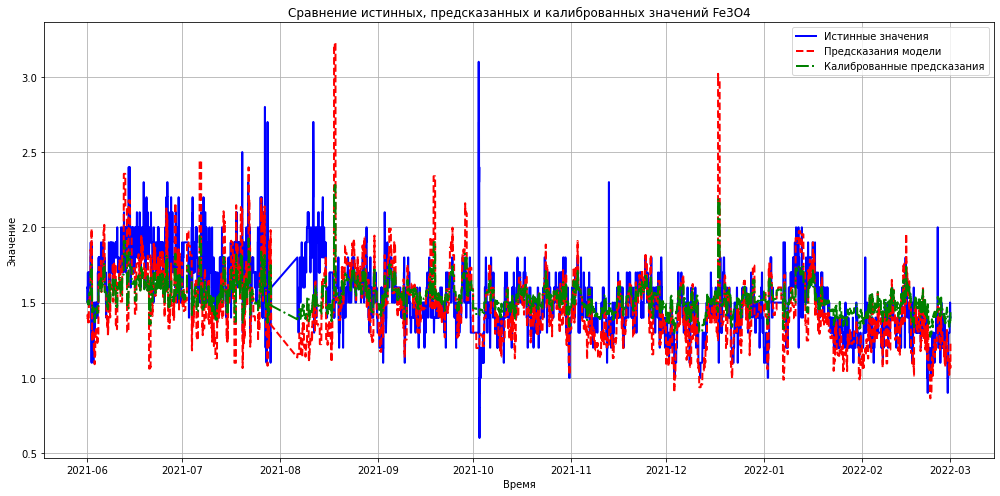

In [168]:
plt.figure(figsize=(14, 7)) 

plt.plot(Fe3O4_data['DateTime'], Fe3O4_data['Fe3O4_final'], label='Истинные значения', color='blue', marker='', linestyle='-', linewidth=2)
plt.plot(Fe3O4_data['DateTime'], Fe3O4_data['Fe3O4_pred'], label='Предсказания модели', color='red', marker='', linestyle='--', linewidth=2)
plt.plot(Fe3O4_data['DateTime'], calibrated_predictions, label='Калиброванные предсказания', color='green', marker='', linestyle='-.', linewidth=2)

plt.xlabel('Время')  
plt.ylabel('Значение')  
plt.title('Сравнение истинных, предсказанных и калиброванных значений Fe3O4') 
plt.legend()  
plt.grid(True)  
plt.tight_layout()  

plt.show()

Видно, что калибровка уменьшает среднее квадратичное отклонение.

### 3) Математическая модель - вычисление плотности

Плотность смеси в баке (берем средневзвешенную плотность относительно массы веществ):

$$ρ_{final} = \frac{sum(mi • ρi)}{M_{total}}$$


Объем конечной смеси в баке, обновляем с учетом изменения плотности:


$$V_{final} = \frac{M_{total}}{ρ_{final}}$$

In [237]:
def calculate_density(df, total_volume = 13.53):
    
    df = df.copy()
    df['M1'] = df['ro1'] * df['ust1']
    df['M2'] = df['ro2'] * df['ust2']
    df['M3'] = df['ro3'] * df['ust3']
    df['M4'] = df['ro4'] * df['ust4']
    
    M_total = df[['M1', 'M2', 'M3', 'M4']].sum(axis=1)
    ro_pred = (df['M1']*df['ro1'] + df['M2']*df['ro2'] + df['M3']*df['ro3'] + df['M4']*df['ro4']) / M_total
    v_pred = M_total / ro_pred
    free = total_volume - v_pred
    
    ro = pd.DataFrame({'ro_pred': ro_pred, 'ro_final': df['ro_final'], 'DateTime': df['DateTime']})

    return ro

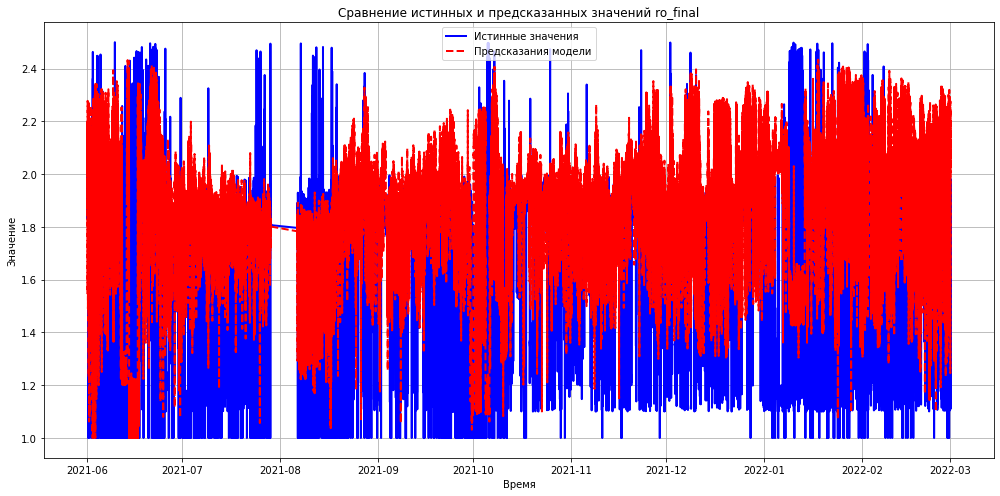

MSE: 0.12866740875939006


In [238]:
ro_data = calculate_density(df1, total_volume = 13.53)
plt.figure(figsize=(14, 7)) 

plt.plot(ro_data['DateTime'], ro_data['ro_final'], label='Истинные значения', color='blue', marker='', linestyle='-', linewidth=2)
plt.plot(ro_data['DateTime'], ro_data['ro_pred'], label='Предсказания модели', color='red', marker='', linestyle='--', linewidth=2)

plt.xlabel('Время')  
plt.ylabel('Значение')  
plt.title('Сравнение истинных и предсказанных значений ro_final') 
plt.legend()  
plt.grid(True)  
plt.tight_layout()  

plt.show()

mse = mean_squared_error(y, ro_data['ro_pred'])

print(f'MSE: {mse}')

### 4) Модель 2

Учитываем объём бака при расчёте уровня заполненности бака.
Проверяем, что суммарный объём добавляемых веществ не превышает объём бака.
Корректируем вычисления концентраций веществ в баке, используя общую массу и объём бака.

In [265]:
VOLUME_TANK = 13.53 

# def calculate_concentrations_and_density(df):
    
#     df = df.copy()
#     df['ni_q'] = (df['Ni1']*df['ust1']*df['ro1'] + df['Ni2']*df['ust2']*df['ro2'] + df['Ni3']*df['ust3']*df['ro3'] + df['Ni4']*df['ust4']*df['ro4'])
#     df['s_q'] = (df['S1']*df['ust1']*df['ro1'] + df['S2']*df['ust2']*df['ro2'] + df['S3']*df['ust3']*df['ro3'] + df['S4']*df['ust4']*df['ro4'])
#     df['fe3o4_q'] = (df['Fe3O41']*df['ust1']*df['ro1'] + df['Fe3O42']*df['ust2']*df['ro2'] + df['Fe3O43']*df['ust3']*df['ro3'] + df['Fe3O44']*df['ust4']*df['ro4'])

#     df['Q'] = (df['ust1'] + df['ust2'] + df['ust3'] + df['ust4'])
#     df['Q'] = df['Q'].apply(lambda x: min(x, VOLUME_TANK))
#     df['v_final'] = df['v_final'] + df['Q']
#     df.loc[df['v_final'] > VOLUME_TANK, 'v_final'] = VOLUME_TANK
    
#     df['ni_final'] = df.apply(lambda x: x['ni_q'] / VOLUME_TANK if x['v_final'] == VOLUME_TANK else x['ni_q'] / x['v_final'], axis=1)
#     df['s_final'] = df.apply(lambda x: x['s_q'] / VOLUME_TANK if x['v_final'] == VOLUME_TANK else x['s_q'] / x['v_final'], axis=1)
#     df['fe3o4_final'] = df.apply(lambda x: x['fe3o4_q'] / VOLUME_TANK if x['v_final'] == VOLUME_TANK else x['fe3o4_q'] / x['v_final'], axis=1)
    
#     df['ro_final'] = (df['ust1']*df['ro1'] + df['ust2']*df['ro2'] + df['ust3']*df['ro3'] + df['ust4']*df['ro4']) / df['Q']
#     df['ro_final'] = df.apply(lambda x: x['ro_final'] * (x['Q'] / x['v_final']), axis=1)
    
#     return df

In [266]:
# final_df = calculate_final_concentrations_and_density(df)
# print(final_df[['ni_final', 's_final', 'fe3o4_final', 'ro_final']])

In [267]:
# plt.figure(figsize=(14, 7)) 

# plt.plot(final_df['DateTime'], final_df['ro_final'], label='Предсказания модели', color='blue', marker='', linestyle='-', linewidth=2)
# plt.plot(df1['DateTime'], df1['ro_final'], label='Истинные значения', color='red', marker='', linestyle='--', linewidth=2)

# mse = mean_squared_error(df1['ro_final'], final_df['ro_final'])
# print(f'MSE: {mse}')

### Этап 3. Целевая функция и алгоритм

In [150]:
N_target = 7.5 
S_target = 25.5  
Fe3O4_target = 1.7 

In [183]:
def target_function(q, df, N_target, S_target, Fe3O4_target):
    df_updated = df.copy()
    df_updated[['ust1', 'ust2', 'ust3', 'ust4']] = q
    
    Ni = math_model_Ni(df_updated)
    S = math_model_S(df_updated)
    Fe3O4 = math_model_Fe3O4(df_updated)

    X1 = Ni['Ni_pred'].values.reshape(-1, 1) 
    calibrated_Ni = calibration_model_Ni.predict(X1)
    X2 = S['S_pred'].values.reshape(-1, 1) 
    calibrated_S = calibration_model_S.predict(X2)
    X3 = Fe3O4['Fe3O4_pred'].values.reshape(-1, 1) 
    calibrated_Fe3O4 = calibration_model_S.predict(X3)
    
    
    Ni_error = np.mean((calibrated_Ni - N_target) **2)
    S_error = np.mean((calibrated_S - S_target) ** 2)
    Fe3O4_error = np.mean((calibrated_Fe3O4 - Fe3O4_target) ** 2)
    
    total_error = np.sum(Ni_error + S_error + Fe3O4_error)
    return total_error

In [184]:
q_initial = df1[['ust1', 'ust2', 'ust3', 'ust4']].iloc[0].values

result = minimize(fun=target_function, x0=q_initial, args=(df1, N_target, S_target, Fe3O4_target), method='SLSQP')

if result.success:
    optimized_ust = result.x
    print("Оптимизированные значения уставок:", optimized_ust)
else:
    print("Оптимизация не удалась:", result.message)

Оптимизированные значения уставок: [ 167.55393171  -70.84281072 -109.46152536  110.42995869]
